In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pyswarms as ps

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Dropout, LSTM, Input, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from collections import Counter

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import class_weight
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
%%html
<style>
  table{float:left}
</style>


Loading Dataset


In [ ]:
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "attack_type",
    "difficulty_level"
]



train_path = "/content/drive/MyDrive/Intrusion_Detection/archive (2)/KDDTrain+.txt"
test_path = "/content/drive/MyDrive/Intrusion_Detection/archive (2)/KDDTest+.txt"

train_data = pd.read_csv(train_path, names=column_names, header=None)
test_data = pd.read_csv(test_path, names=column_names, header=None)


print("Train Data shape:",train_data.shape)
print("Test Data shape:",test_data.shape)


print("Sample Train Data:\n")
train_data


Train Data shape: (125973, 43)
Test Data shape: (22544, 43)
Sample Train Data:



duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0                    0       0    0  ...                    0.17   
1                    0       0    0  ...                    0.00   
2                    0       0    0  ...                    0.10   
3                    0       0    0  ...                    1.00   
4                    0       0    0  ...                    1.00   
...                ...     ...  ...  ...                     ...   
125968               0       0    0  ...                    0.10   
125969               0       0    0  ...                    0.96   
125970               0       0    0  ...                    0.12   
125971               0       0    0  ...                    0.03   
125972               0       0    0  ...                    0.30   

        dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                         0.03                         0.17   
1                         0.60                         0.88   
2                         0.05                         0.00   
3                         0.00                         0.03   
4                         0.00                         0.00   
...                        ...                          ...   
125968                    0.06                         0.00   
125969                    0.01                         0.01   
125970                    0.06                         0.00   
125971                    0.05                         0.00   
125972                    0.03                         0.30   

        dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                              0.00                  0.00   
1                              0.00                  0.00   
2                              0.00                  1.00   
3                              0.04                  0.03   
4                              0.00                  0.00   
...                             ...                   ...   
125968                         0.00                  1.00   
125969                         0.00                  0.00   
125970                         0.00                  0.72   
125971                         0.00                  1.00   
125972                         0.00                  0.00   

        dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                           0.00                  0.05   
1                           0.00                  0.00   
2                           1.00                  0.00   
3                           0.01                  0.00   
4                           0.00                  0.00   
...                          ...                   ...   
125968                      1.00                  0.00   
125969                      0.00                  0.00   
125970                      0.00                  0.01   
125971                      1.00                  0.00   
125972                      0.00                  0.00   

        dst_host_srv_rerror_rate  attack_type  difficulty_level  
0            

Exploratory Data Analysis

In [ ]:
def print_section(title, length=80):
  seperator = "#" * (length)
  print(f"\n{seperator}")
  print(title.center(length))
  print(f"{seperator}\n")

print_section("Train Data Info")
train_data.info()

print_section("Test Data Info")
test_data.info()

print_section("Attack Type Distribution (Train)")
print(train_data["attack_type"].value_counts())
print(f"Sum of all total attack_type: {train_data['attack_type'].value_counts().sum()}")

print_section("Attack Type Distribution (Test)")
print(test_data["attack_type"].value_counts())
print(f"Sum of all total attack_type: {test_data['attack_type'].value_counts().sum()}")


################################################################################
                                Train Data Info                                 
################################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int

Grouping Attacks into Categories
*   DoS (Denial of Service)

*   Probe (Scanning/Reconnaissance)

*   R2L (Remote to Local)


*   U2R (User to Root Escalation)

In [ ]:
# define attack type groups
dos_attacks = [
    "back",
    "land",
    "neptune",
    "pod",
    "smurf",
    "teardrop",
    "apache2",
    "udpstorm",
    "processtable",
    "mailbomb"
]
probe_attacks = [
    "satan",
    "ipsweep",
    "nmap",
    "portsweep",
    "mscan",
    "saint"
]
r2l_attacks = [
    "guess_passwd",
    "ftp_write",
    "imap",
    "phf",
    "multihop",
    "warezmaster",
    "warezclient",
    "spy",
    "xlock",
    "xsnoop",
    "snmpguess",
    "snmpgetattack",
    "httptunnel",
    "sendmail",
    "named"
]
u2r_attacks = [
    "rootkit",
    "buffer_overflow",
    "loadmodule",
    "perl",
    "sqlattack",
    "xterm",
    "ps"
]



def map_attack_type(attack):
  if attack in dos_attacks:
    return "DoS"
  elif attack in probe_attacks:
    return "Probe"
  elif attack in r2l_attacks:
    return "R2L"
  elif attack in u2r_attacks:
    return "U2R"
  elif attack == "normal":
    return "Normal"
  else:
    return "Other"


train_data ["attack_category"] = train_data["attack_type"].apply(map_attack_type)

test_data["attack_category"] = test_data["attack_type"].apply(map_attack_type)

print_section("Attack Category Distribution (Train)")
print(train_data["attack_category"].value_counts())
print(f"Sum of all total attack_type from attack_category: {train_data['attack_category'].value_counts().sum()}")

print_section("Attack Category Distribution (Test)")
print(test_data["attack_category"].value_counts())
print(f"Sum of all total attack_type from attack_category: {test_data['attack_category'].value_counts().sum()}")


################################################################################
                      Attack Category Distribution (Train)                      
################################################################################

attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64
Sum of all total attack_type from attack_category: 125973

################################################################################
                      Attack Category Distribution (Test)                       
################################################################################

attack_category
Normal    9711
DoS       7458
R2L       2885
Probe     2421
U2R         67
Other        2
Name: count, dtype: int64
Sum of all total attack_type from attack_category: 22544


Data Visualization


In [ ]:

def plot_multiple_pie_charts(data, group_by_col, value_col, title_prefix, threshold=0.01):
    """
    Generates pie chart with an "Other" category and better readability.

    Parameters:
        data (DataFrame): The dataset to use.
        group_by_col (str): The column to group by (e.g., 'protocol_type', 'attack_status').
        value_col (str): The column to count (e.g., 'attack_category', 'flag', 'service').
        title_prefix (str): A title prefix for each chart.
        threshold (float): The minimum percentage a slice should have to remain separate.
    """
    # get unique values in the grouping column
    unique_groups = data[group_by_col].unique()
    # create subplots dynamically based on the number of unique groups
    fig, axes = plt.subplots(1, len(unique_groups), figsize=(28, 10))

    if len(unique_groups) == 1:
        axes = [axes]

    # loop through each unique group and create a pie chart
    for i, group in enumerate(unique_groups):
        subset = data[data[group_by_col] == group]
        counts = subset[value_col].value_counts()
        total = counts.sum()

        # separate small values into "Other" category
        mask = counts / total >= threshold
        small_slices = counts[~mask].sum()
        counts = counts[mask]
        if small_slices > 0:
            counts['Other'] = small_slices

        # generate explode values dynamically
        explode = [0.1 if (v / total) >= 0.1 else 0.05 for v in counts.values]

        # create a pie chart
        wedges, texts, autotexts = axes[i].pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=140,
            explode=explode,
            colors=plt.get_cmap("tab20").colors,
            shadow=True,
            wedgeprops={'edgecolor': 'black'}
        )

        # improve label readability
        for text in texts:
            text.set_fontsize(10)
        for autotext in autotexts:
            autotext.set_fontsize(12)
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        # set title for each subplot
        axes[i].set_title(f"{title_prefix} {group}", fontsize=18, fontweight='bold')
        # add a legend for each chart
        axes[i].legend(wedges, counts.index, title=value_col, loc="best", fontsize=12)

    plt.tight_layout()
    plt.show()

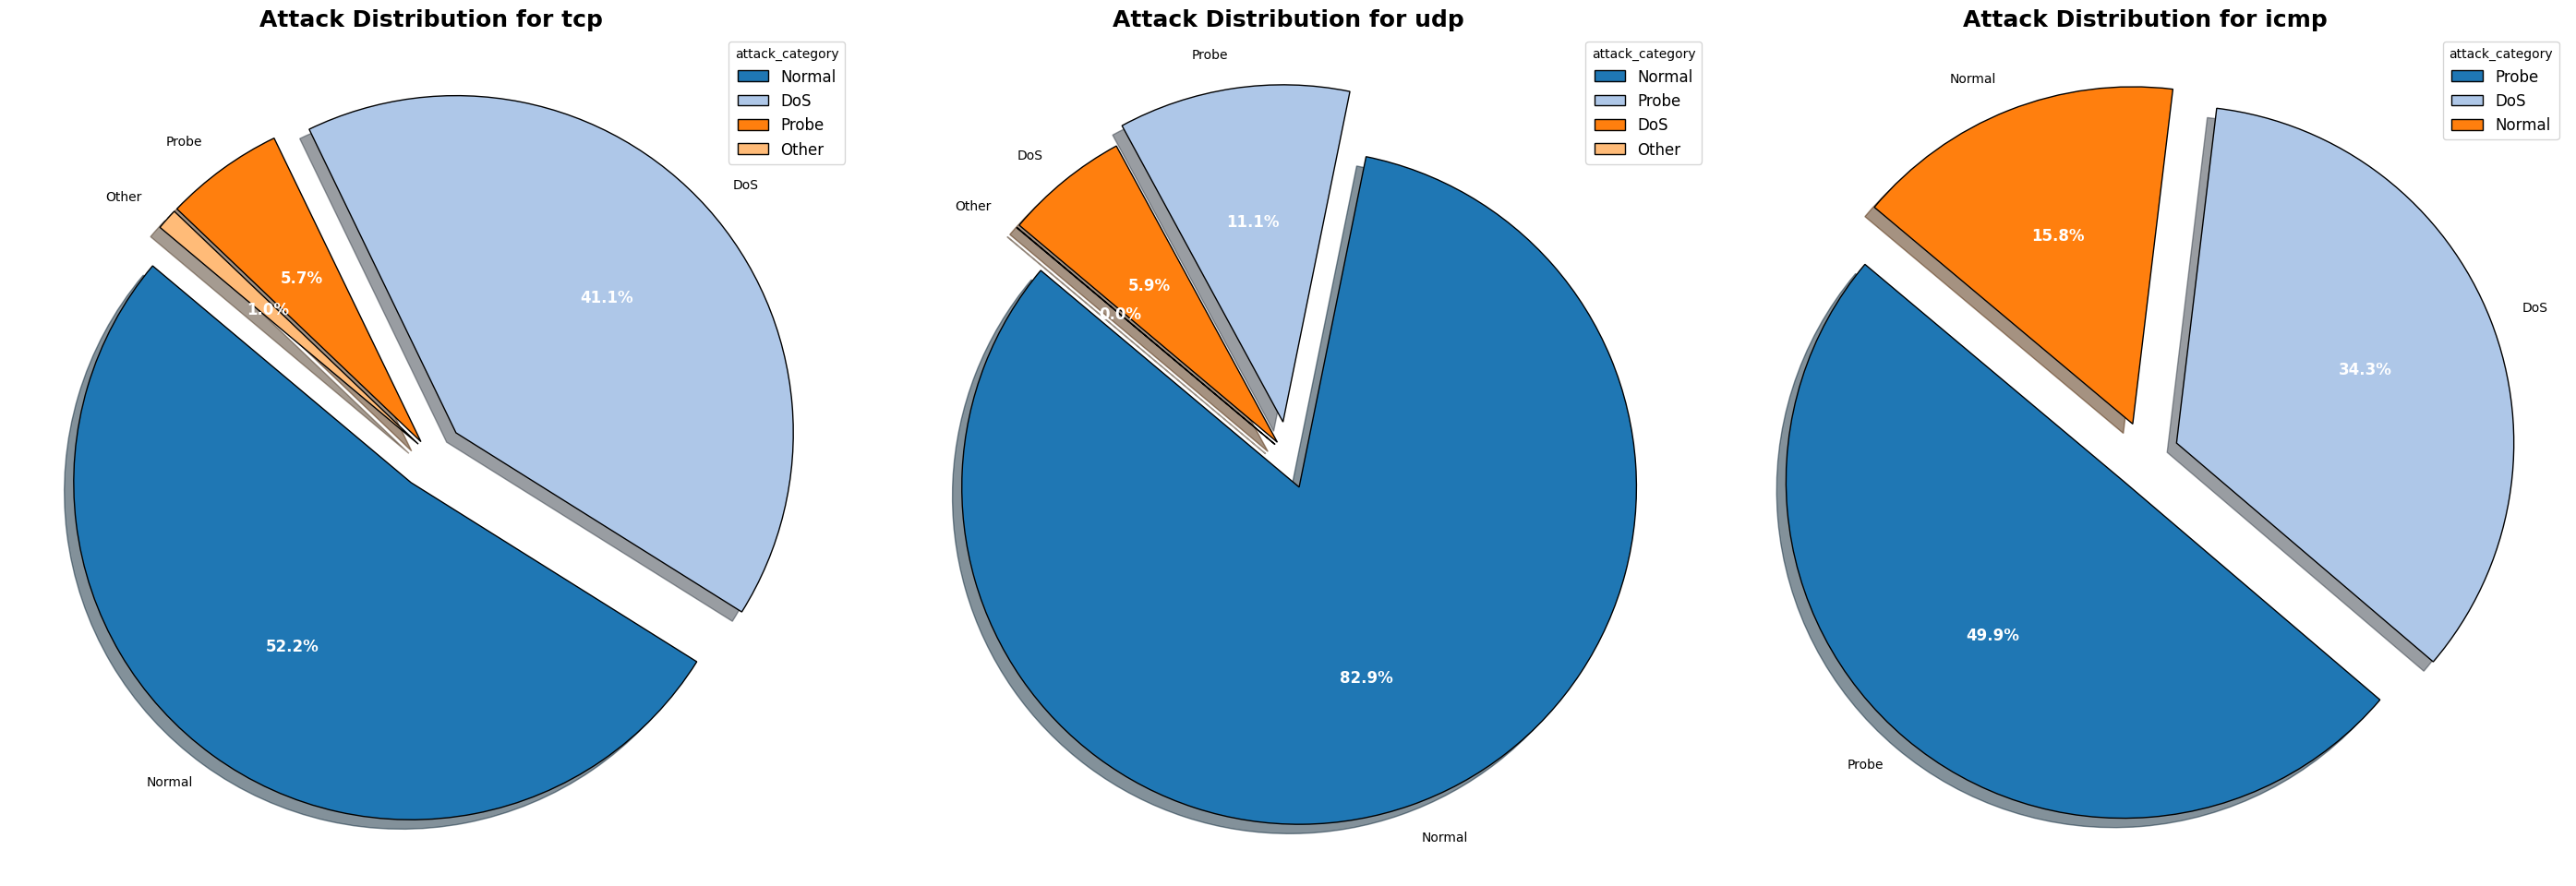

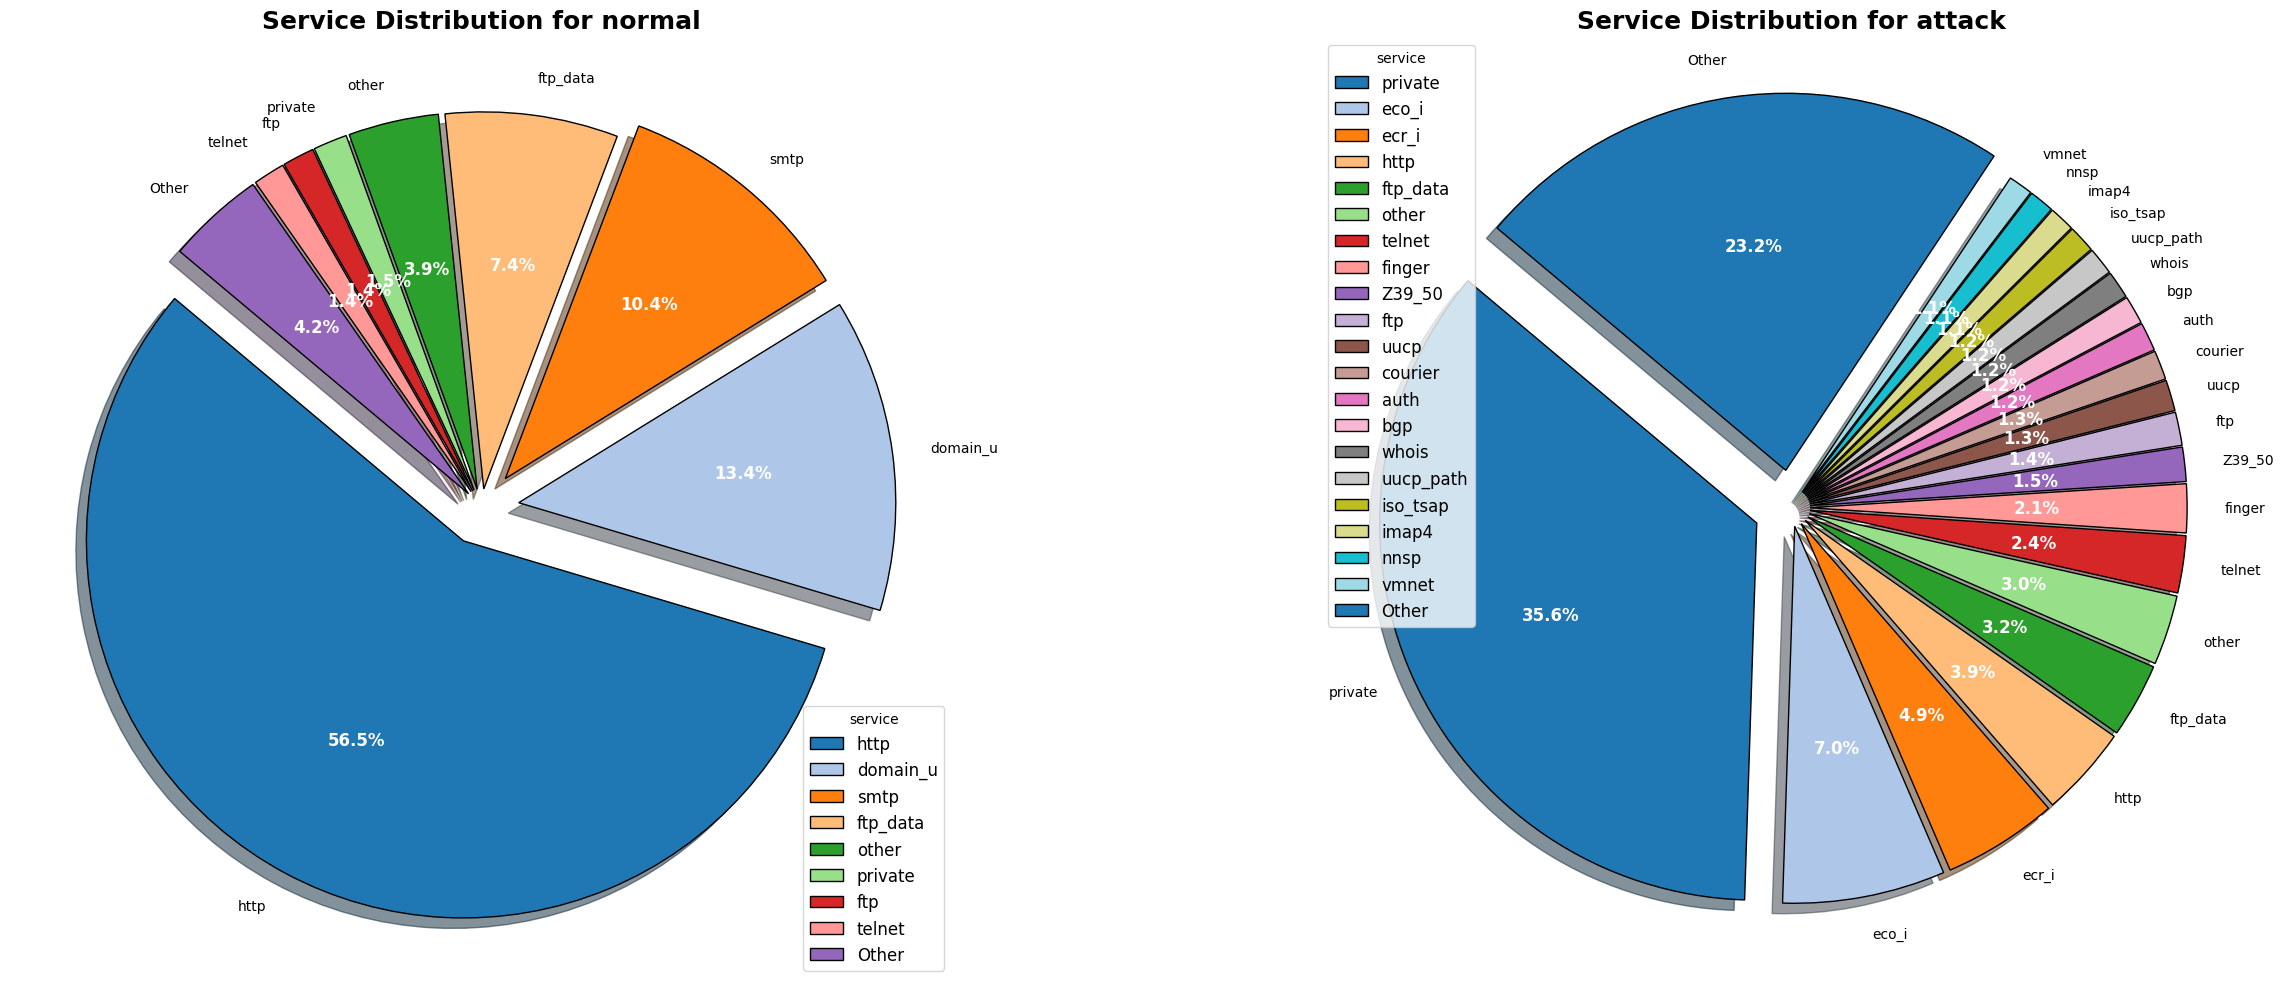

In [ ]:
# attack Distribution by Protocol Type
plot_multiple_pie_charts(train_data, "protocol_type", "attack_category", "Attack Distribution for")

# service Distribution for Normal vs. Attack Traffic
train_data["attack_status"] = train_data["attack_category"].apply(
    lambda x: "attack" if x != "Normal" else "normal"
)

plot_multiple_pie_charts(
    train_data,
    "attack_status",
    "service",
    "Service Distribution for"
)


In [ ]:

categorical_cols = ["protocol_type", "service", "flag"]

# apply Label Encoding to categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

# encode Attack Categories Numerically
attack_category_encoder = LabelEncoder()
attack_category_encoder.fit(pd.concat([train_data["attack_category"], test_data["attack_category"]], axis=0))

train_data["attack_category_encoded"] = attack_category_encoder.transform(train_data["attack_category"])
test_data["attack_category_encoded"]  = attack_category_encoder.transform(test_data["attack_category"])

In [ ]:
train_data


duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0              0              1       20     9        491          0     0   
1              0              2       44     9        146          0     0   
2              0              1       49     5          0          0     0   
3              0              1       24     9        232       8153     0   
4              0              1       24     9        199        420     0   
...          ...            ...      ...   ...        ...        ...   ...   
125968         0              1       49     5          0          0     0   
125969         8              2       49     9        105        145     0   
125970         0              1       54     9       2231        384     0   
125971         0              1       30     5          0          0     0   
125972         0              1       20     9        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_diff_host_rate  \
0                    0       0    0  ...                         0.00   
1                    0       0    0  ...                         0.00   
2                    0       0    0  ...                         0.00   
3                    0       0    0  ...                         0.04   
4                    0       0    0  ...                         0.00   
...                ...     ...  ...  ...                          ...   
125968               0       0    0  ...                         0.00   
125969               0       0    0  ...                         0.00   
125970               0       0    0  ...                         0.00   
125971               0       0    0  ...                         0.00   
125972               0       0    0  ...                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.05   
1                       0.00                      0.00                  0.00   
2                       1.00                      1.00                  0.00   
3                       0.03                      0.01                  0.00   
4                       0.00                      0.00                  0.00   
...                      ...                       ...                   ...   
125968                  1.00                      1.00                  0.00   
125969                  0.00                      0.00                  0.00   
125970                  0.72                      0.00                  0.01   
125971                  1.00                      1.00                  0.00   
125972                  0.00                      0.00                  0.00   

        dst_host_srv_rerror_rate  attack_type  difficulty_level  \
0                           0.00       normal                20   
1                           0.00       normal                15   
2                           0.00      neptune                19   
3                           0.01       normal                21   
4                           0.00       normal                21   
...                          ...          ...               ...   
125968                      0.00      neptune                20   
125969                      0.00       normal                21   
125970                      0.00       normal                18   
125971                      0.00      neptune                20   
125972                      0.00       normal                21   

        attack_category  attack_status  attack_category_encoded  
0                Normal         normal                        1  
1                Normal         normal                        1  
2                   DoS         attack                        0  
3                Normal         normal                        1  
4                Normal         normal                        1  
...                 ...         

In [ ]:
test_data

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0             0              1       49     1          0          0     0   
1             0              1       49     1          0          0     0   
2             2              1       20     9      12983          0     0   
3             0              0       14     9         20          0     0   
4             1              1       60     2          0         15     0   
...         ...            ...      ...   ...        ...        ...   ...   
22539         0              1       54     9        794        333     0   
22540         0              1       24     9        317        938     0   
22541         0              1       24     9      54540       8314     0   
22542         0              2       12     9         42         42     0   
22543         0              1       57     1          0          0     0   

       wrong_fragment  urgent  hot  ...  dst_host_same_src_port_rate  \
0                   0       0    0  ...                         0.00   
1                   0       0    0  ...                         0.00   
2                   0       0    0  ...                         0.61   
3                   0       0    0  ...                         1.00   
4                   0       0    0  ...                         0.03   
...               ...     ...  ...  ...                          ...   
22539               0       0    0  ...                         0.01   
22540               0       0    0  ...                         0.01   
22541               0       0    2  ...                         0.00   
22542               0       0    0  ...                         0.00   
22543               0       0    0  ...                         0.00   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                             0.00                  0.00   
1                             0.00                  0.00   
2                             0.02                  0.00   
3                             0.28                  0.00   
4                             0.02                  0.00   
...                            ...                   ...   
22539                         0.01                  0.01   
22540                         0.01                  0.01   
22541                         0.00                  0.00   
22542                         0.00                  0.00   
22543                         0.00                  0.00   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                           0.0                  1.00   
1                           0.0                  1.00   
2                           0.0                  0.00   
3                           0.0                  0.00   
4                           0.0                  0.83   
...                         ...                   ...   
22539                       0.0                  0.00   
22540                       0.0                  0.00   
22541                       0.0                  0.07   
22542                       0.0                  0.00   
22543                       0.0                  0.44   

       dst_host_srv_rerror_rate  attack_type  difficulty_level  \
0                          1.00      neptune                21   
1                          1.00      neptune                21   
2                          0.00       normal                21   
3                          0.00        saint                15   
4                          0.71        mscan                11   
...                         ...          ...               ...   
22539                      0.00       normal                21   
22540                      0.00       normal                21   
22541                      0.07         back                15   
22542                      0.00       normal                21   
22543                      1.00        mscan                14   

       attack_cate

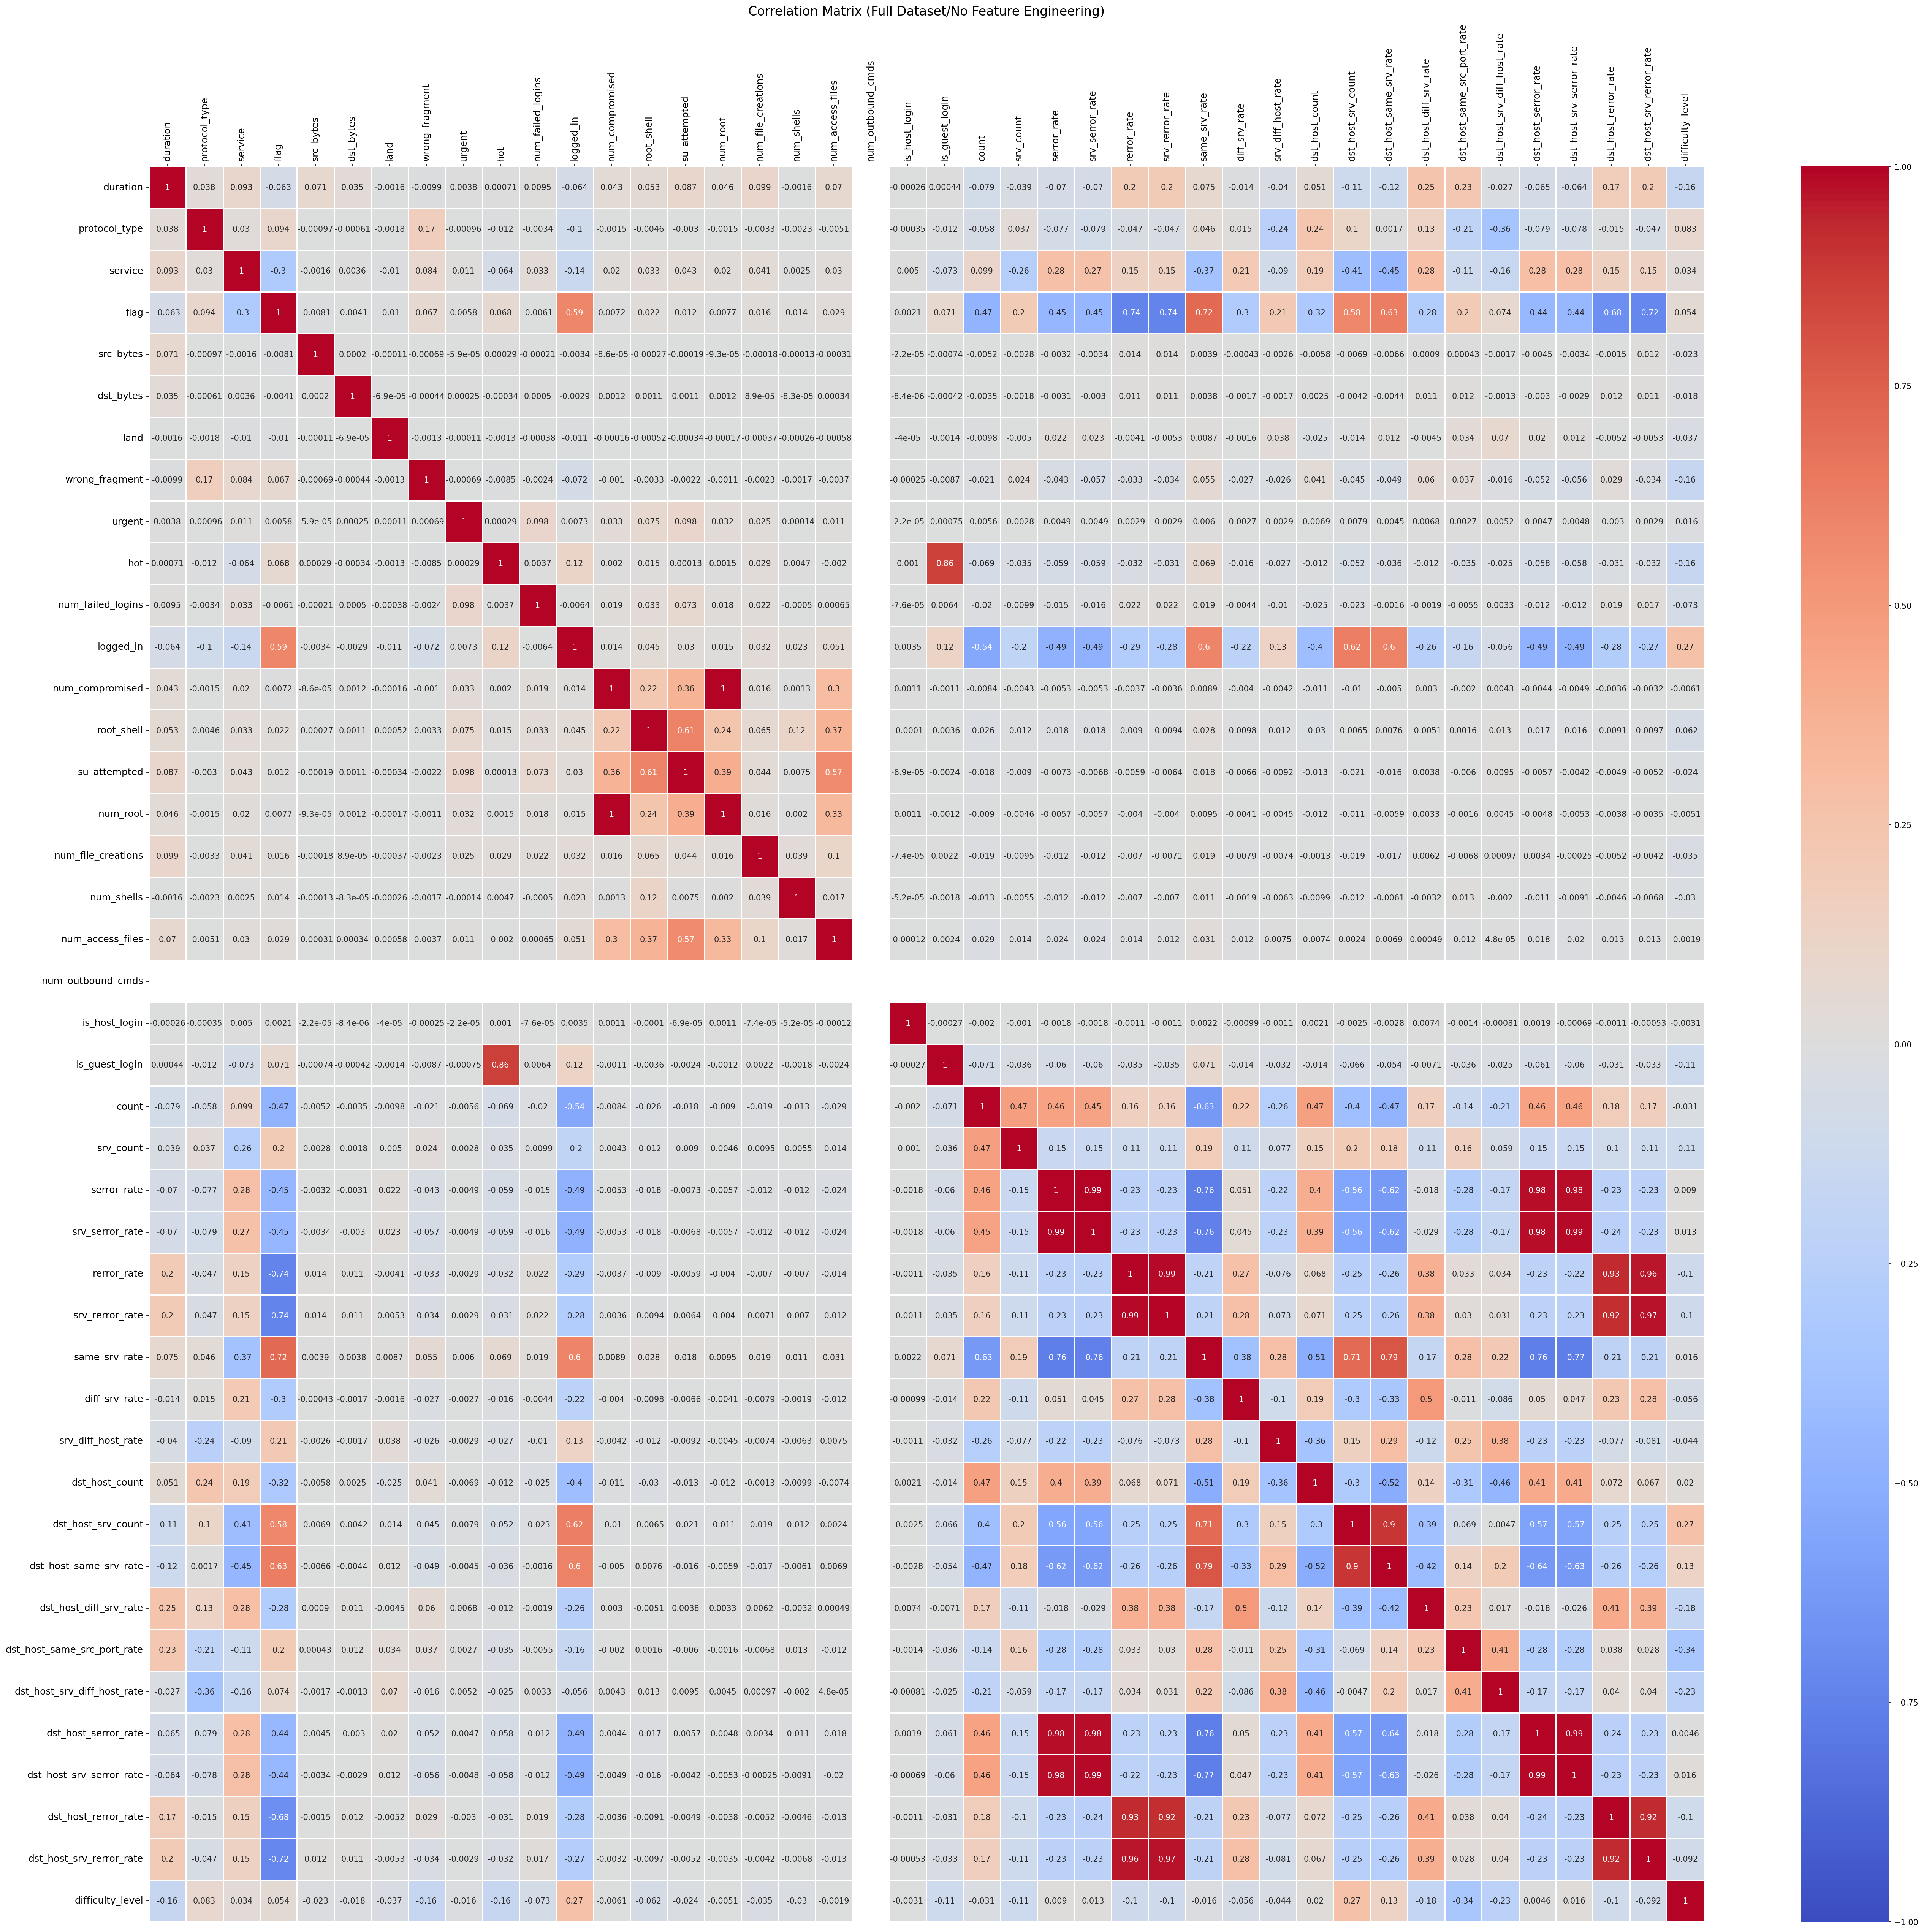

In [ ]:

# correlation Matrix before feature engineering
# runtime warning is expected
plt.figure(figsize=(44, 40), dpi=150)
ax = sns.heatmap(
    train_data.drop(
        columns=["attack_type", "attack_category", "attack_status", "attack_category_encoded"], errors="ignore"
    ).corr(), cmap='coolwarm', annot=True, linewidths=0.5, vmin=-1, vmax=1
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title("Correlation Matrix (Full Dataset/No Feature Engineering)", fontsize=16, pad=10)
plt.show()


In [ ]:

# keep a copy of the original dataset for tree-based models
train_data_full = train_data.copy()
test_data_full = test_data.copy()

# create a separate dataset for feature selection
train_data_reduced = train_data.copy()
test_data_reduced = test_data.copy()

text_cols = ["attack_type", "attack_category", "attack_status"]
train_data_reduced.drop(columns=text_cols, inplace=True, errors='ignore')
test_data_reduced.drop(columns=text_cols, inplace=True, errors='ignore')

# --- 1: Variance Threshold/Constant Features ---
print_section("Low Variance Features / Constant Features")
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(train_data_reduced.drop(columns=["attack_category_encoded"]))
low_variance_features = train_data_reduced.drop(columns=['attack_category_encoded']).columns[
    var_thresh.get_support(False) == False
].tolist()

print(f"features to drop due to low variance/constant: {low_variance_features}")

# drop them
train_data_reduced.drop(columns=low_variance_features, inplace=True)
test_data_reduced.drop(columns=low_variance_features, inplace=True, errors='ignore')

# --- 2: Correlation Threshold ---
print_section("Correlated Features")
reduced_corr_matrix = train_data_reduced.drop(columns=['attack_category_encoded']).corr()
correlation_threshold = 0.70
correlated_features = set()

cols = reduced_corr_matrix.columns
for i in range(len(cols)):
    for j in range(i):
        if abs(reduced_corr_matrix.iloc[i, j]) > correlation_threshold:
            correlated_features.add(cols[i])

print(f"features to drop due to high correlation (> {correlation_threshold}): {correlated_features}")

# drop them
train_data_reduced.drop(columns=list(correlated_features), inplace=True, errors='ignore')
test_data_reduced.drop(columns=list(correlated_features), inplace=True, errors='ignore')


# --- 3: Variance Inflation Factor (VIF) ---
print_section("Variance Inflation Factor")
numeric_cols = [c for c in train_data_reduced.columns if c != 'attack_category_encoded']
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols
vif_data["VIF"] = [
    variance_inflation_factor(train_data_reduced[numeric_cols].values, idx)
    for idx in range(len(numeric_cols))
]

vif_threshold = 10
vif_features_to_drop = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
print(f"features to drop due to VIF > {vif_threshold}: {vif_features_to_drop}")

# drop them
train_data_reduced.drop(columns=vif_features_to_drop, inplace=True, errors='ignore')
test_data_reduced.drop(columns=vif_features_to_drop, inplace=True, errors='ignore')

print_section("Feature Selection Complete (Reduced Dataset)")
print("train_data_reduced shape:", train_data_reduced.shape)
print("test_data_reduced shape: ", test_data_reduced.shape)
print("train_data_full shape:   ", train_data_full.shape)
print("test_data_full shape:    ", test_data_full.shape)


################################################################################
                   Low Variance Features / Constant Features                    
################################################################################

features to drop due to low variance/constant: ['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']

################################################################################
                              Correlated Features                               
################################################################################

features to drop due to high correlation (> 0.7): {'srv_rerror_rate', 'num_root', 'dst_host_rerror_rate', 'rerror_rate', 'srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_srv_count', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate', 'same_srv_rate', 'dst_host_srv_serror_rate'}

#################

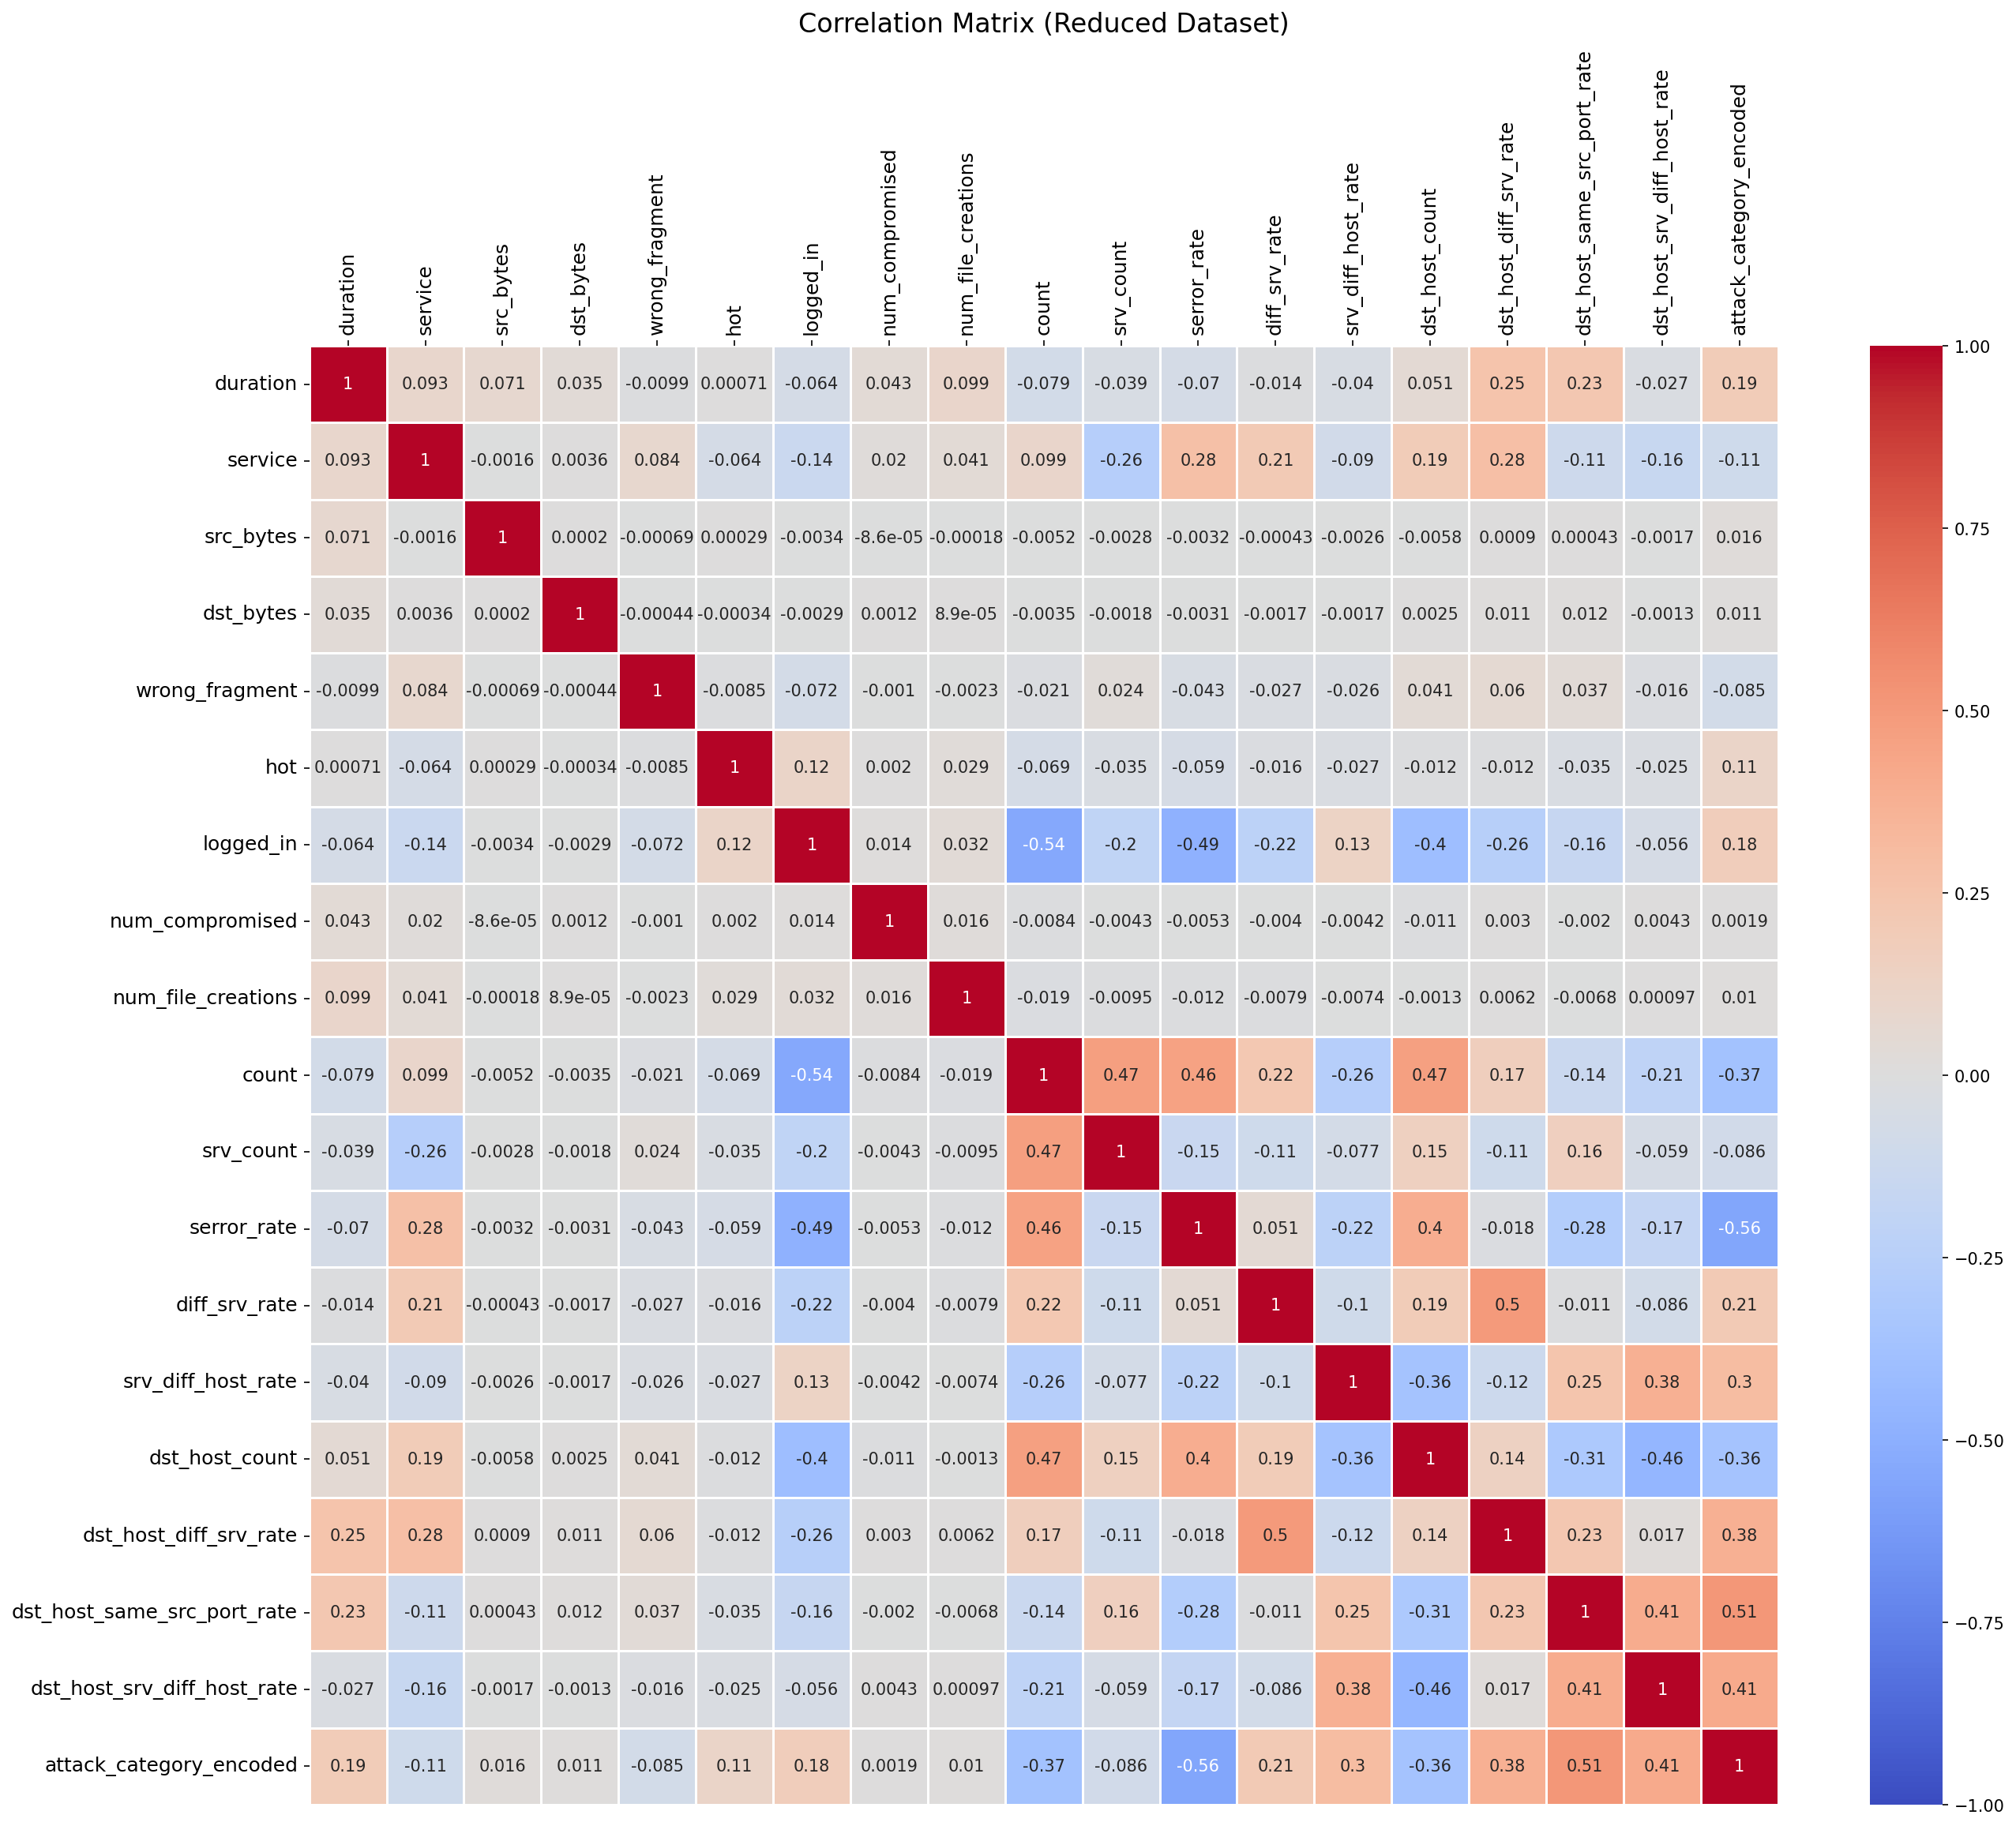

In [ ]:
plt.figure(figsize=(20, 16), dpi=150)
ax = sns.heatmap(train_data_reduced.corr(), cmap='coolwarm', annot=True, linewidths=0.5, vmin=-1, vmax=1)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.title("Correlation Matrix (Reduced Dataset)", fontsize=16, pad=10)
plt.show()

In [ ]:
train_data_full


duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0              0              1       20     9        491          0     0   
1              0              2       44     9        146          0     0   
2              0              1       49     5          0          0     0   
3              0              1       24     9        232       8153     0   
4              0              1       24     9        199        420     0   
...          ...            ...      ...   ...        ...        ...   ...   
125968         0              1       49     5          0          0     0   
125969         8              2       49     9        105        145     0   
125970         0              1       54     9       2231        384     0   
125971         0              1       30     5          0          0     0   
125972         0              1       20     9        151          0     0   

        wrong_fragment  urgent  hot  ...  dst_host_srv_diff_host_rate  \
0                    0       0    0  ...                         0.00   
1                    0       0    0  ...                         0.00   
2                    0       0    0  ...                         0.00   
3                    0       0    0  ...                         0.04   
4                    0       0    0  ...                         0.00   
...                ...     ...  ...  ...                          ...   
125968               0       0    0  ...                         0.00   
125969               0       0    0  ...                         0.00   
125970               0       0    0  ...                         0.00   
125971               0       0    0  ...                         0.00   
125972               0       0    0  ...                         0.00   

        dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                       0.00                      0.00                  0.05   
1                       0.00                      0.00                  0.00   
2                       1.00                      1.00                  0.00   
3                       0.03                      0.01                  0.00   
4                       0.00                      0.00                  0.00   
...                      ...                       ...                   ...   
125968                  1.00                      1.00                  0.00   
125969                  0.00                      0.00                  0.00   
125970                  0.72                      0.00                  0.01   
125971                  1.00                      1.00                  0.00   
125972                  0.00                      0.00                  0.00   

        dst_host_srv_rerror_rate  attack_type  difficulty_level  \
0                           0.00       normal                20   
1                           0.00       normal                15   
2                           0.00      neptune                19   
3                           0.01       normal                21   
4                           0.00       normal                21   
...                          ...          ...               ...   
125968                      0.00      neptune                20   
125969                      0.00       normal                21   
125970                      0.00       normal                18   
125971                      0.00      neptune                20   
125972                      0.00       normal                21   

        attack_category  attack_status  attack_category_encoded  
0                Normal         normal                        1  
1                Normal         normal                        1  
2                   DoS         attack                        0  
3                Normal         normal                        1  
4                Normal         normal                        1  
...                 ...         

In [ ]:
test_data_full


duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0             0              1       49     1          0          0     0   
1             0              1       49     1          0          0     0   
2             2              1       20     9      12983          0     0   
3             0              0       14     9         20          0     0   
4             1              1       60     2          0         15     0   
...         ...            ...      ...   ...        ...        ...   ...   
22539         0              1       54     9        794        333     0   
22540         0              1       24     9        317        938     0   
22541         0              1       24     9      54540       8314     0   
22542         0              2       12     9         42         42     0   
22543         0              1       57     1          0          0     0   

       wrong_fragment  urgent  hot  ...  dst_host_same_src_port_rate  \
0                   0       0    0  ...                         0.00   
1                   0       0    0  ...                         0.00   
2                   0       0    0  ...                         0.61   
3                   0       0    0  ...                         1.00   
4                   0       0    0  ...                         0.03   
...               ...     ...  ...  ...                          ...   
22539               0       0    0  ...                         0.01   
22540               0       0    0  ...                         0.01   
22541               0       0    2  ...                         0.00   
22542               0       0    0  ...                         0.00   
22543               0       0    0  ...                         0.00   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                             0.00                  0.00   
1                             0.00                  0.00   
2                             0.02                  0.00   
3                             0.28                  0.00   
4                             0.02                  0.00   
...                            ...                   ...   
22539                         0.01                  0.01   
22540                         0.01                  0.01   
22541                         0.00                  0.00   
22542                         0.00                  0.00   
22543                         0.00                  0.00   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                           0.0                  1.00   
1                           0.0                  1.00   
2                           0.0                  0.00   
3                           0.0                  0.00   
4                           0.0                  0.83   
...                         ...                   ...   
22539                       0.0                  0.00   
22540                       0.0                  0.00   
22541                       0.0                  0.07   
22542                       0.0                  0.00   
22543                       0.0                  0.44   

       dst_host_srv_rerror_rate  attack_type  difficulty_level  \
0                          1.00      neptune                21   
1                          1.00      neptune                21   
2                          0.00       normal                21   
3                          0.00        saint                15   
4                          0.71        mscan                11   
...                         ...          ...               ...   
22539                      0.00       normal                21   
22540                      0.00       normal                21   
22541                      0.07         back                15   
22542                      0.00       normal                21   
22543                      1.00        mscan                14   

       attack_cate

In [ ]:
train_data_reduced


duration  service  src_bytes  dst_bytes  wrong_fragment  hot  \
0              0       20        491          0               0    0   
1              0       44        146          0               0    0   
2              0       49          0          0               0    0   
3              0       24        232       8153               0    0   
4              0       24        199        420               0    0   
...          ...      ...        ...        ...             ...  ...   
125968         0       49          0          0               0    0   
125969         8       49        105        145               0    0   
125970         0       54       2231        384               0    0   
125971         0       30          0          0               0    0   
125972         0       20        151          0               0    0   

        logged_in  num_compromised  num_file_creations  count  srv_count  \
0               0                0                   0      2          2   
1               0                0                   0     13          1   
2               0                0                   0    123          6   
3               1                0                   0      5          5   
4               1                0                   0     30         32   
...           ...              ...                 ...    ...        ...   
125968          0                0                   0    184         25   
125969          0                0                   0      2          2   
125970          1                0                   0      1          1   
125971          0                0                   0    144          8   
125972          1                0                   0      1          1   

        serror_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  \
0               0.0           0.00                0.00             150   
1               0.0           0.15                0.00             255   
2               1.0           0.07                0.00             255   
3               0.2           0.00                0.00              30   
4               0.0           0.00                0.09             255   
...             ...            ...                 ...             ...   
125968          1.0           0.06                0.00             255   
125969          0.0           0.00                0.00             255   
125970          0.0           0.00                0.00             255   
125971          1.0           0.05                0.00             255   
125972          0.0           0.00                0.00             255   

        dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                         0.03                         0.17   
1                         0.60                         0.88   
2                         0.05                         0.00   
3                         0.00                         0.03   
4                         0.00                         0.00   
...                        ...                          ...   
125968                    0.06                         0.00   
125969                    0.01                         0.01   
125970                    0.06                         0.00   
125971                    0.05                         0.00   
125972                    0.03                         0.30   

        dst_host_srv_diff_host_rate  attack_category_encoded  
0                              0.00                        1  
1                              0.00                        1  
2                              0.00                        0  
3                              0.04                        1  
4                              0.00                        1  
...                             ...                      ...  
125968                         0.00                        0  
125969                         0.00                        1  
125970           

In [ ]:
test_data_reduced


duration  service  src_bytes  dst_bytes  wrong_fragment  hot  \
0             0       49          0          0               0    0   
1             0       49          0          0               0    0   
2             2       20      12983          0               0    0   
3             0       14         20          0               0    0   
4             1       60          0         15               0    0   
...         ...      ...        ...        ...             ...  ...   
22539         0       54        794        333               0    0   
22540         0       24        317        938               0    0   
22541         0       24      54540       8314               0    2   
22542         0       12         42         42               0    0   
22543         0       57          0          0               0    0   

       logged_in  num_compromised  num_file_creations  count  srv_count  \
0              0                0                   0    229         10   
1              0                0                   0    136          1   
2              0                0                   0      1          1   
3              0                0                   0      1         65   
4              0                0                   0      1          8   
...          ...              ...                 ...    ...        ...   
22539          1                0                   0      1          1   
22540          1                0                   0      2         11   
22541          1                1                   0      5         10   
22542          0                0                   0      4          6   
22543          0                0                   0      4         10   

       serror_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  \
0              0.0           0.06                0.00             255   
1              0.0           0.06                0.00             255   
2              0.0           0.00                0.00             134   
3              0.0           0.00                1.00               3   
4              0.0           0.00                0.75              29   
...            ...            ...                 ...             ...   
22539          0.0           0.00                0.00             100   
22540          0.0           0.00                0.18             197   
22541          0.0           0.00                0.20             255   
22542          0.0           0.00                0.33             255   
22543          0.0           1.00                1.00             255   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                        0.06                         0.00   
1                        0.06                         0.00   
2                        0.04                         0.61   
3                        0.00                         1.00   
4                        0.17                         0.03   
...                       ...                          ...   
22539                    0.06                         0.01   
22540                    0.00                         0.01   
22541                    0.00                         0.00   
22542                    0.01                         0.00   
22543                    0.03                         0.00   

       dst_host_srv_diff_host_rate  attack_category_encoded  
0                             0.00                        0  
1                             0.00                        0  
2                             0.02                        1  
3                             0.28                        3  
4                             0.02                        3  
...                            ...                      ...  
22539                         0.01                        1  
22540                         0.01                        1  
22541                         0.00                        0  
22542      

In [ ]:

# --- 1: preparing Data for Tree-Based Models ---
X_full_train = train_data_full.drop(columns=["attack_type", "attack_category", "attack_status", "attack_category_encoded"], errors="ignore")
y_full_train = train_data_full["attack_category_encoded"]

X_full_test = test_data_full.drop(columns=["attack_type", "attack_category", "attack_category_encoded"], errors="ignore")
y_full_test = test_data_full["attack_category_encoded"]

# --- 2: Preparing Data for Linear Models ---
X_reduced_train = train_data_reduced.drop(columns=["attack_category_encoded"], errors="ignore")
y_reduced_train = train_data_reduced["attack_category_encoded"]

X_reduced_test = test_data_reduced.drop(columns=["attack_category_encoded"], errors="ignore")
y_reduced_test = test_data_reduced["attack_category_encoded"]

# --- 3: apply SMOTE to balance dataset before training all models ---
print_section("After applying SMOTE to balance dataset")
smote = SMOTE(random_state=42)
X_full_train_resampled, y_full_train_resampled = smote.fit_resample(X_full_train, y_full_train)
X_reduced_train_resampled, y_reduced_train_resampled = smote.fit_resample(X_reduced_train, y_reduced_train)
print(Counter(y_full_train_resampled))
print(Counter(y_reduced_train_resampled))


################################################################################
                    After applying SMOTE to balance dataset                     
################################################################################

Counter({1: 67343, 0: 67343, 4: 67343, 3: 67343, 5: 67343})
Counter({1: 67343, 0: 67343, 4: 67343, 3: 67343, 5: 67343})



################################################################################
                        Training RandomForestClassifier                         
################################################################################

Accuracy: 0.7824
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86      7458
           1       0.71      0.97      0.82      9711
           2       1.00      0.00      0.00         2
           3       0.74      0.80      0.77      2421
           4       0.94      0.16      0.28      2885
           5       0.35      0.36      0.35        67

    accuracy                           0.78     22544
   macro avg       0.78      0.51      0.51     22544
weighted avg       0.82      0.78      0.76     22544



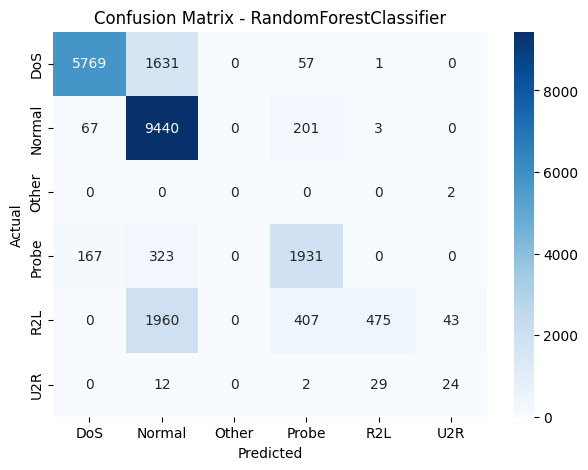


################################################################################
                    Training HistGradientBoostingClassifier                     
################################################################################

Accuracy: 0.8194
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7458
           1       0.76      0.97      0.85      9711
           2       1.00      0.00      0.00         2
           3       0.75      0.80      0.77      2421
           4       0.95      0.27      0.43      2885
           5       0.19      0.43      0.26        67

    accuracy                           0.82     22544
   macro avg       0.77      0.55      0.54     22544
weighted avg       0.85      0.82      0.80     22544



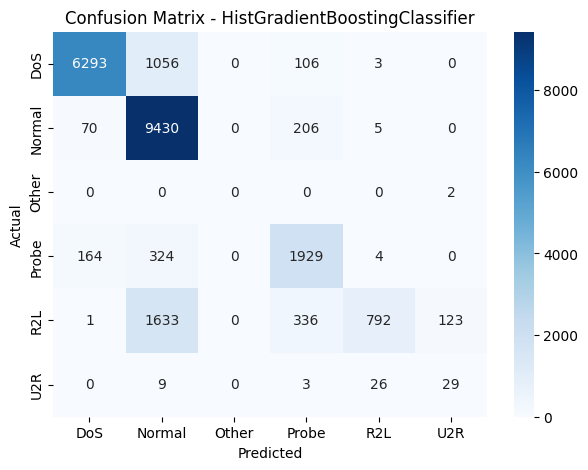


################################################################################
                          Training LogisticRegression                           
################################################################################

Accuracy: 0.7005
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80      7458
           1       0.67      0.85      0.75      9711
           2       1.00      0.00      0.00         2
           3       0.67      0.76      0.71      2421
           4       0.39      0.06      0.10      2885
           5       0.04      0.58      0.08        67

    accuracy                           0.70     22544
   macro avg       0.61      0.50      0.41     22544
weighted avg       0.71      0.70      0.68     22544



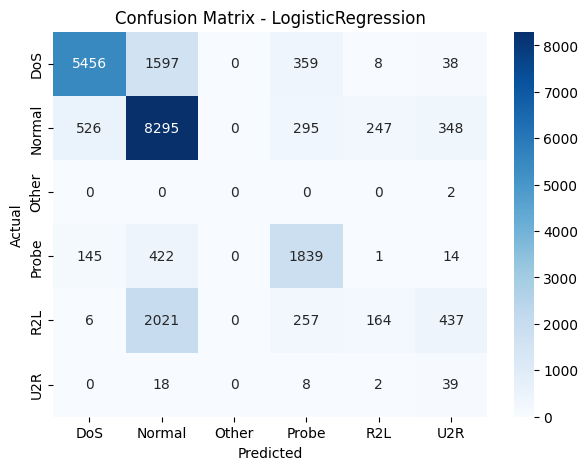

In [ ]:

# helper preprocessing function for models that require scaling
def scale_data_set(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)

# model config keys
RANDOM_FOREST_CLASSIFIER = "RandomForestClassifier"
HIST_GRADIENT_BOOSTING_CLASSIFIER = "HistGradientBoostingClassifier"
LOGISTIC_REGRESSION = "LogisticRegression"
ESTIMATOR = "estimator"
DATASET = "dataset"
PRE_PROCESSOR = "preprocessor"
FULL = "full"
REDUCED = "reduced"

# configuration dictionary mapping each model name to its estimator, dataset type,
# and (optionally) a preprocessor function
model_configs = {
    RANDOM_FOREST_CLASSIFIER: {
         ESTIMATOR: RandomForestClassifier(min_samples_split=10, random_state=42),
         DATASET: FULL
    },
    HIST_GRADIENT_BOOSTING_CLASSIFIER: {
         ESTIMATOR: HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, random_state=42),
         DATASET: FULL
    },
    LOGISTIC_REGRESSION: {
         ESTIMATOR: LogisticRegression(max_iter=2000, solver="newton-cg", random_state=42),
         DATASET: REDUCED,
         PRE_PROCESSOR: scale_data_set
    }
}

# dataset keys
X_TRAIN = "X_train"
Y_TRAIN = "y_train"
X_TEST = "X_test"
Y_TEST = "y_test"

# mapping of dataset types to their corresponding train and test sets
dataset_mapping = {
    FULL: {
        X_TRAIN: X_full_train_resampled,
        Y_TRAIN: y_full_train_resampled,
        X_TEST: X_full_test,
        Y_TEST: y_full_test
    },
    REDUCED: {
        X_TRAIN: X_reduced_train_resampled,
        Y_TRAIN: y_reduced_train_resampled,
        X_TEST: X_reduced_test,
        Y_TEST: y_reduced_test
    }
}

# labels for each class
class_labels = attack_category_encoder.classes_

# train & evaluate
for model_name, config in model_configs.items():
    print_section(f"Training {model_name}")

    # get the dataset based on the config
    dataset_type = config[DATASET]
    data = dataset_mapping[dataset_type]
    X_train, y_train = data[X_TRAIN], data[Y_TRAIN]
    X_test, y_test = data[X_TEST], data[Y_TEST]

    # apply a model-specific preprocessor if provided
    if PRE_PROCESSOR in config:
        X_train, X_test = config[PRE_PROCESSOR](X_train, X_test)

    # fit and evaluate the model
    model = config[ESTIMATOR]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # plot Confusion Matrix with Labels
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 5), dpi=100)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()




In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
X_train_res, y_train_res = X_reduced_train_resampled, y_reduced_train_resampled
X_test_df, y_test = X_reduced_test, y_reduced_test
X_train, X_test = scale_data_set(X_train_res,X_test_df)

num_classes = np.max(y_train)+1
y_train_cat = to_categorical(y_train_res,num_classes)
y_test_cat = to_categorical(y_test,num_classes)

n_features = X_train.shape[1]
X_train_seq = X_train.reshape(-1, n_features, 1)
X_test_seq = X_test.reshape(-1,n_features,1)

print(X_train_seq.shape[0], y_train_cat.shape[0])
print(X_test_seq.shape[0],y_test_cat.shape[0])

336715 336715
22544 22544


In [ ]:
# --- objective function for PSO ---
def fitness_func(hyperparams):
    """
    hyperparams is an array of shape (n_particles, n_dims)
    dims: [lr, dropout, filters1, dense_units]
    returns: 1D array of loss (we'll minimize loss = -val_acc)
    """
    losses = []
    print("im inside the fitness func")
    for particle in hyperparams:
        lr, dropout_rate, f1, dense_u = particle
        # cast discrete dims to ints
        filters1    = int(np.round(f1))
        dense_units = int(np.round(dense_u))

        # build a small CNN
        model = Sequential([
            Input(shape=(n_features,1)),
            Conv1D(filters1, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Conv1D(filters1*2, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model.summary()
        # train only for a few epochs to speed up search
        print("started model training")
        history = model.fit(
            X_train_seq, y_train_cat,
            epochs=3,
            batch_size=64,
            validation_split=0.2,
        )
        print("finished model training")
        # negative best val_accuracy (because PSO minimizes)
        val_acc = max(history.history['val_accuracy'])
        losses.append(-val_acc)
    return np.array(losses)

In [ ]:
# --- set up PSO ---
# 4 dims: [lr, dropout, filters1, dense_units]
bounds = (
    [1e-4,    0.0,   16,   64],   # min
    [1e-2,    0.5,   64,  256]    # max
)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# GlobalBestPSO: you can tune n_particles and iters as you have budget for
optimizer = ps.single.GlobalBestPSO(
    n_particles=6, dimensions=4, options=options, bounds=bounds
)

# --- perform the optimization ---
best_cost, best_pos = optimizer.optimize(
    fitness_func, iters=10, verbose=2
)

# unpack best hyperparams
best_lr, best_dropout, best_f1, best_dense = best_pos
best_filters1    = int(np.round(best_f1))
best_dense_units = int(np.round(best_dense))

print("Best validation accuracy = {:.4f}".format(-best_cost))
print("Optimized hyperparameters:")
print(f" • learning rate:    {best_lr:.5f}")
print(f" • dropout rate:     {best_dropout:.2f}")
print(f" • Conv1D filters1:  {best_filters1}")
print(f" • Dense units:      {best_dense_units}")

2025-05-06 23:43:13,304 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

im inside the fitness func


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 16, 63)         │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 63)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 126)         │        23,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 126)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 378)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 213)            │        80,727 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 213)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,203 (414.86 KB)

 Trainable params: 106,203 (414.86 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9483 - loss: 0.1666 - val_accuracy: 0.1961 - val_loss: 4.7743
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9801 - loss: 0.0585 - val_accuracy: 0.0546 - val_loss: 5.8857
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9838 - loss: 0.0491 - val_accuracy: 0.2485 - val_loss: 6.5450
finished model training


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 16, 45)         │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 45)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 90)          │        12,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 90)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 241)            │        65,311 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 241)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,183 (309.31 KB)

 Trainable params: 79,183 (309.31 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9460 - loss: 0.1790 - val_accuracy: 7.7217e-04 - val_loss: 7.6980
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9726 - loss: 0.0855 - val_accuracy: 7.7217e-04 - val_loss: 8.9017
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9730 - loss: 0.0975 - val_accuracy: 0.0183 - val_loss: 7.8765
finished model training


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 16, 18)         │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 8, 18)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 6, 36)          │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 3, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 126)            │        13,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           762 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,548 (64.64 KB)

 Trainable params: 16,548 (64.64 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9168 - loss: 0.2563 - val_accuracy: 7.5732e-04 - val_loss: 6.6485
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9728 - loss: 0.0787 - val_accuracy: 0.0016 - val_loss: 5.4080
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9794 - loss: 0.0582 - val_accuracy: 0.0462 - val_loss: 4.7760
finished model training


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 132)            │        44,484 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           798 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,434 (251.70 KB)

 Trainable params: 64,434 (251.70 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9479 - loss: 0.1633 - val_accuracy: 7.7217e-04 - val_loss: 5.5347
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9800 - loss: 0.0596 - val_accuracy: 0.0608 - val_loss: 5.4504
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9839 - loss: 0.0473 - val_accuracy: 0.3006 - val_loss: 5.4925
finished model training


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 16, 23)         │            92 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 8, 23)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 6, 46)          │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 3, 46)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 218)            │        30,302 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 218)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,314 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,928 (136.44 KB)

 Trainable params: 34,928 (136.44 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9407 - loss: 0.1844 - val_accuracy: 7.5732e-04 - val_loss: 5.9686
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9781 - loss: 0.0635 - val_accuracy: 0.1763 - val_loss: 5.9453
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9835 - loss: 0.0498 - val_accuracy: 0.2512 - val_loss: 5.8700
finished model training


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 16, 53)         │           212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 8, 53)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 6, 106)         │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 3, 106)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 318)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 102)            │        32,538 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           618 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,328 (196.59 KB)

 Trainable params: 50,328 (196.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9212 - loss: 0.2555 - val_accuracy: 7.5732e-04 - val_loss: 7.7581
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9702 - loss: 0.0869 - val_accuracy: 7.7217e-04 - val_loss: 6.6001
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9764 - loss: 0.0693 - val_accuracy: 7.5732e-04 - val_loss: 6.2099


pyswarms.single.global_best:  10%|█         |1/10, best_cost=-0.301

finished model training
im inside the fitness func


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 16, 63)         │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 8, 63)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 6, 126)         │        23,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 3, 126)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 378)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 211)            │        79,969 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 211)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         1,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,433 (411.85 KB)

 Trainable params: 105,433 (411.85 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9006 - loss: 0.3315 - val_accuracy: 7.5732e-04 - val_loss: 7.3424
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9655 - loss: 0.1011 - val_accuracy: 7.7217e-04 - val_loss: 6.2508
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9724 - loss: 0.0792 - val_accuracy: 7.7217e-04 - val_loss: 5.5397
finished model training


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 16, 48)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 8, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 6, 96)          │        13,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 3, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 213)            │        61,557 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 213)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,953 (300.60 KB)

 Trainable params: 76,953 (300.60 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9032 - loss: 0.3198 - val_accuracy: 7.5732e-04 - val_loss: 7.7787
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9654 - loss: 0.1010 - val_accuracy: 7.5732e-04 - val_loss: 6.7764
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9732 - loss: 0.0772 - val_accuracy: 7.7217e-04 - val_loss: 5.8023
finished model training


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 16, 23)         │            92 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 8, 23)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 6, 46)          │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 3, 46)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 127)            │        17,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 127)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,733 (84.89 KB)

 Trainable params: 21,733 (84.89 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9454 - loss: 0.1710 - val_accuracy: 7.5732e-04 - val_loss: 8.3661
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9773 - loss: 0.0707 - val_accuracy: 0.0511 - val_loss: 6.9053
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9823 - loss: 0.0539 - val_accuracy: 0.1002 - val_loss: 6.5384
finished model training


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_18 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_19 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 133)            │        44,821 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,777 (253.04 KB)

 Trainable params: 64,777 (253.04 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9421 - loss: 0.1878 - val_accuracy: 7.7217e-04 - val_loss: 7.4918
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9744 - loss: 0.0795 - val_accuracy: 9.2066e-04 - val_loss: 7.1692
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9783 - loss: 0.0677 - val_accuracy: 7.7217e-04 - val_loss: 9.6587
finished model training


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)              │ (None, 16, 26)         │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_20 (MaxPooling1D) │ (None, 8, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 6, 52)          │         4,108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 3, 52)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 156)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 194)            │        30,458 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 194)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,840 (140.00 KB)

 Trainable params: 35,840 (140.00 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9473 - loss: 0.1668 - val_accuracy: 0.0148 - val_loss: 6.3308
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9752 - loss: 0.0740 - val_accuracy: 0.0449 - val_loss: 7.9314
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9788 - loss: 0.0660 - val_accuracy: 0.1080 - val_loss: 9.0150
finished model training


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)              │ (None, 16, 54)         │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 8, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 6, 108)         │        17,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 3, 108)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 105)            │        34,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,581 (205.39 KB)

 Trainable params: 52,581 (205.39 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9383 - loss: 0.1949 - val_accuracy: 7.5732e-04 - val_loss: 8.8197
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9748 - loss: 0.0760 - val_accuracy: 7.7217e-04 - val_loss: 7.2683
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9795 - loss: 0.0657 - val_accuracy: 7.7217e-04 - val_loss: 6.5938


pyswarms.single.global_best:  20%|██        |2/10, best_cost=-0.301

finished model training
im inside the fitness func


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 16, 61)         │           244 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 8, 61)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 6, 122)         │        22,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 3, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 366)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 209)            │        76,703 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 209)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │         1,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,655 (393.18 KB)

 Trainable params: 100,655 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9448 - loss: 0.1805 - val_accuracy: 0.0102 - val_loss: 6.7746
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9756 - loss: 0.0773 - val_accuracy: 0.1320 - val_loss: 6.4958
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9799 - loss: 0.0617 - val_accuracy: 0.2511 - val_loss: 8.7351
finished model training


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)              │ (None, 16, 51)         │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 8, 51)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 6, 102)         │        15,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 3, 102)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 306)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 187)            │        57,409 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 187)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │         1,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,449 (290.82 KB)

 Trainable params: 74,449 (290.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9366 - loss: 0.2025 - val_accuracy: 7.7217e-04 - val_loss: 6.3948
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9762 - loss: 0.0734 - val_accuracy: 0.0015 - val_loss: 5.0715
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9820 - loss: 0.0534 - val_accuracy: 0.2865 - val_loss: 4.6214
finished model training


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 16, 37)         │           148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 8, 37)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 6, 74)          │         8,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 3, 74)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 222)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        28,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,754 (147.48 KB)

 Trainable params: 37,754 (147.48 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9353 - loss: 0.2043 - val_accuracy: 7.7217e-04 - val_loss: 6.5253
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9768 - loss: 0.0662 - val_accuracy: 0.0023 - val_loss: 4.8752
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9831 - loss: 0.0490 - val_accuracy: 0.1454 - val_loss: 4.6497
finished model training


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 133)            │        45,619 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,259 (258.82 KB)

 Trainable params: 66,259 (258.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9499 - loss: 0.1614 - val_accuracy: 7.5732e-04 - val_loss: 7.7940
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9779 - loss: 0.0672 - val_accuracy: 0.0628 - val_loss: 7.6084
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9804 - loss: 0.0615 - val_accuracy: 0.1541 - val_loss: 6.7914
finished model training


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 16, 36)         │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 8, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 6, 72)          │         7,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 3, 72)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 168)            │        36,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 6)              │         1,014 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,462 (177.59 KB)

 Trainable params: 45,462 (177.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9460 - loss: 0.1720 - val_accuracy: 7.7217e-04 - val_loss: 5.8247
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9807 - loss: 0.0562 - val_accuracy: 0.2808 - val_loss: 4.6557
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9851 - loss: 0.0447 - val_accuracy: 0.2668 - val_loss: 5.0087
finished model training


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)              │ (None, 16, 55)         │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 8, 55)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 6, 110)         │        18,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 3, 110)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 115)            │        38,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 115)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           696 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,241 (223.60 KB)

 Trainable params: 57,241 (223.60 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9414 - loss: 0.1848 - val_accuracy: 7.4247e-04 - val_loss: 7.1725
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9737 - loss: 0.0801 - val_accuracy: 0.0174 - val_loss: 7.7910
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9779 - loss: 0.0668 - val_accuracy: 7.5732e-04 - val_loss: 8.6940


pyswarms.single.global_best:  30%|███       |3/10, best_cost=-0.301

finished model training
im inside the fitness func


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)              │ (None, 16, 59)         │           236 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 8, 59)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 6, 118)         │        21,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 3, 118)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 188)            │        66,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 188)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 6)              │         1,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,114 (348.10 KB)

 Trainable params: 89,114 (348.10 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9438 - loss: 0.1805 - val_accuracy: 7.5732e-04 - val_loss: 8.9834
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9708 - loss: 0.0936 - val_accuracy: 7.5732e-04 - val_loss: 7.6489
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9745 - loss: 0.0806 - val_accuracy: 7.7217e-04 - val_loss: 9.4558
finished model training


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 16, 53)         │           212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 8, 53)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 6, 106)         │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 3, 106)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 318)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 158)            │        50,402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 158)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           954 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,528 (267.69 KB)

 Trainable params: 68,528 (267.69 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9194 - loss: 0.2609 - val_accuracy: 7.5732e-04 - val_loss: 7.0821
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9717 - loss: 0.0824 - val_accuracy: 7.7217e-04 - val_loss: 5.8190
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9795 - loss: 0.0607 - val_accuracy: 7.7217e-04 - val_loss: 5.3887
finished model training


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 16, 55)         │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 8, 55)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 6, 110)         │        18,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 3, 110)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 129)            │        42,699 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 129)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 6)              │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,959 (242.03 KB)

 Trainable params: 61,959 (242.03 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9488 - loss: 0.1678 - val_accuracy: 0.0523 - val_loss: 4.6331
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9772 - loss: 0.0686 - val_accuracy: 0.0425 - val_loss: 7.3862
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9814 - loss: 0.0566 - val_accuracy: 0.3537 - val_loss: 5.5761
finished model training


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 133)            │        45,619 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,259 (258.82 KB)

 Trainable params: 66,259 (258.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9458 - loss: 0.1699 - val_accuracy: 7.7217e-04 - val_loss: 7.1795
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9786 - loss: 0.0657 - val_accuracy: 0.1267 - val_loss: 5.3699
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9831 - loss: 0.0521 - val_accuracy: 0.3092 - val_loss: 5.7806
finished model training


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)              │ (None, 16, 45)         │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 8, 45)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 6, 90)          │        12,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 3, 90)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 137)            │        37,127 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 137)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 6)              │           828 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,375 (196.78 KB)

 Trainable params: 50,375 (196.78 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9455 - loss: 0.1745 - val_accuracy: 7.5732e-04 - val_loss: 6.9147
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9746 - loss: 0.0881 - val_accuracy: 0.0406 - val_loss: 5.7275
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9796 - loss: 0.0613 - val_accuracy: 0.2172 - val_loss: 6.2953
finished model training


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 125)            │        42,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │           756 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,033 (242.32 KB)

 Trainable params: 62,033 (242.32 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9474 - loss: 0.1751 - val_accuracy: 7.7217e-04 - val_loss: 8.8844
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9757 - loss: 0.0744 - val_accuracy: 0.0762 - val_loss: 6.1901
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9805 - loss: 0.0611 - val_accuracy: 0.0240 - val_loss: 7.3548


pyswarms.single.global_best:  40%|████      |4/10, best_cost=-0.354

finished model training
im inside the fitness func


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 161)            │        55,223 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 161)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 6)              │           972 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,031 (297.00 KB)

 Trainable params: 76,031 (297.00 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9282 - loss: 0.2309 - val_accuracy: 7.5732e-04 - val_loss: 6.4085
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9742 - loss: 0.0747 - val_accuracy: 0.0218 - val_loss: 4.9443
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9812 - loss: 0.0554 - val_accuracy: 0.1264 - val_loss: 4.2711
finished model training


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_50 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 138)            │        46,506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 6)              │           834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,492 (259.73 KB)

 Trainable params: 66,492 (259.73 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9433 - loss: 0.1825 - val_accuracy: 7.7217e-04 - val_loss: 6.5791
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9782 - loss: 0.0666 - val_accuracy: 0.0922 - val_loss: 5.8625
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9832 - loss: 0.0517 - val_accuracy: 0.2244 - val_loss: 5.4425
finished model training


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_52 (Conv1D)              │ (None, 16, 23)         │            92 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 8, 23)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 6, 46)          │         3,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 3, 46)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 130)            │        18,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 6)              │           786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,168 (86.59 KB)

 Trainable params: 22,168 (86.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9465 - loss: 0.1730 - val_accuracy: 7.7217e-04 - val_loss: 6.0718
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9761 - loss: 0.0695 - val_accuracy: 0.0050 - val_loss: 5.9173
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9809 - loss: 0.0572 - val_accuracy: 0.1503 - val_loss: 5.7788
finished model training


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 132)            │        44,484 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 6)              │           798 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,434 (251.70 KB)

 Trainable params: 64,434 (251.70 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9466 - loss: 0.1726 - val_accuracy: 7.5732e-04 - val_loss: 6.7519
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9742 - loss: 0.0874 - val_accuracy: 0.0014 - val_loss: 6.4987
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9796 - loss: 0.0618 - val_accuracy: 0.2669 - val_loss: 7.2234
finished model training


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_56 (Conv1D)              │ (None, 16, 52)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 8, 52)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_57 (Conv1D)              │ (None, 6, 104)         │        16,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 3, 104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 111)            │        34,743 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 111)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 6)              │           672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,951 (202.93 KB)

 Trainable params: 51,951 (202.93 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9433 - loss: 0.1812 - val_accuracy: 7.5732e-04 - val_loss: 5.0215
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9807 - loss: 0.0569 - val_accuracy: 0.0492 - val_loss: 4.4453
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9865 - loss: 0.0413 - val_accuracy: 0.2598 - val_loss: 4.8280
finished model training


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_58 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 134)            │        45,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 134)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 6)              │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,608 (260.19 KB)

 Trainable params: 66,608 (260.19 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9435 - loss: 0.1806 - val_accuracy: 7.5732e-04 - val_loss: 5.8227
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.9808 - loss: 0.0572 - val_accuracy: 0.2821 - val_loss: 4.7442
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9862 - loss: 0.0420 - val_accuracy: 0.3322 - val_loss: 4.9065


pyswarms.single.global_best:  50%|█████     |5/10, best_cost=-0.354

finished model training
im inside the fitness func


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)              │ (None, 16, 55)         │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 8, 55)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 6, 110)         │        18,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 3, 110)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 130)            │        43,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 6)              │           786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,296 (243.34 KB)

 Trainable params: 62,296 (243.34 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9442 - loss: 0.1797 - val_accuracy: 0.0017 - val_loss: 6.2300
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9790 - loss: 0.0639 - val_accuracy: 0.1317 - val_loss: 4.2602
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9849 - loss: 0.0451 - val_accuracy: 0.2853 - val_loss: 5.1185
finished model training


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_62 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 133)            │        45,619 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 6)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,259 (258.82 KB)

 Trainable params: 66,259 (258.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9466 - loss: 0.1721 - val_accuracy: 7.7217e-04 - val_loss: 6.2538
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9783 - loss: 0.0661 - val_accuracy: 0.0551 - val_loss: 6.9155
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9821 - loss: 0.0573 - val_accuracy: 0.2598 - val_loss: 5.8686
finished model training


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)              │ (None, 16, 53)         │           212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 8, 53)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 6, 106)         │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 3, 106)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 318)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 131)            │        41,789 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 131)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 6)              │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,753 (233.41 KB)

 Trainable params: 59,753 (233.41 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9391 - loss: 0.1940 - val_accuracy: 7.5732e-04 - val_loss: 6.6805
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9775 - loss: 0.0674 - val_accuracy: 0.0185 - val_loss: 5.6874
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9828 - loss: 0.0524 - val_accuracy: 0.1329 - val_loss: 4.9918
finished model training


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 131)            │        44,147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 131)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 6)              │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,091 (250.36 KB)

 Trainable params: 64,091 (250.36 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9422 - loss: 0.1863 - val_accuracy: 7.7217e-04 - val_loss: 7.1899
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9721 - loss: 0.0866 - val_accuracy: 7.7217e-04 - val_loss: 7.7742
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9754 - loss: 0.0757 - val_accuracy: 7.7217e-04 - val_loss: 12.3897
finished model training


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_68 (Conv1D)              │ (None, 16, 55)         │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 8, 55)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_69 (Conv1D)              │ (None, 6, 110)         │        18,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 3, 110)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 330)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 101)            │        33,431 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 6)              │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,523 (205.17 KB)

 Trainable params: 52,523 (205.17 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9323 - loss: 0.2198 - val_accuracy: 7.5732e-04 - val_loss: 6.6476
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9744 - loss: 0.0729 - val_accuracy: 7.7217e-04 - val_loss: 5.3167
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9813 - loss: 0.0548 - val_accuracy: 0.0035 - val_loss: 4.6192
finished model training


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_70 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 143)            │        49,049 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 143)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 6)              │           864 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,749 (272.46 KB)

 Trainable params: 69,749 (272.46 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9456 - loss: 0.1760 - val_accuracy: 7.4247e-04 - val_loss: 6.9904
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9765 - loss: 0.0716 - val_accuracy: 0.0011 - val_loss: 6.7577
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9792 - loss: 0.0679 - val_accuracy: 0.2618 - val_loss: 6.4238


pyswarms.single.global_best:  60%|██████    |6/10, best_cost=-0.354

finished model training
im inside the fitness func


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 16, 53)         │           212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 8, 53)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 6, 106)         │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 3, 106)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 318)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 102)            │        32,538 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 6)              │           618 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,328 (196.59 KB)

 Trainable params: 50,328 (196.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9376 - loss: 0.1948 - val_accuracy: 7.5732e-04 - val_loss: 7.2119
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9744 - loss: 0.0773 - val_accuracy: 7.7217e-04 - val_loss: 7.0771
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9789 - loss: 0.0658 - val_accuracy: 7.7217e-04 - val_loss: 8.0955
finished model training


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 139)            │        47,677 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 139)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 6)              │           840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,353 (267.00 KB)

 Trainable params: 68,353 (267.00 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9464 - loss: 0.1718 - val_accuracy: 7.4247e-04 - val_loss: 7.6769
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9738 - loss: 0.0817 - val_accuracy: 7.7217e-04 - val_loss: 7.2027
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9775 - loss: 0.0701 - val_accuracy: 0.0802 - val_loss: 7.3603
finished model training


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_76 (Conv1D)              │ (None, 16, 34)         │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 8, 34)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 6, 68)          │         7,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 3, 68)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 204)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 131)            │        26,855 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 131)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 6)              │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,787 (135.89 KB)

 Trainable params: 34,787 (135.89 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9446 - loss: 0.1767 - val_accuracy: 7.5732e-04 - val_loss: 6.6102
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9781 - loss: 0.0679 - val_accuracy: 0.0037 - val_loss: 7.8879
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9828 - loss: 0.0540 - val_accuracy: 0.2891 - val_loss: 6.7042
finished model training


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 130)            │        43,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 6)              │           786 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,748 (249.02 KB)

 Trainable params: 63,748 (249.02 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9417 - loss: 0.1827 - val_accuracy: 7.7217e-04 - val_loss: 5.9257
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9785 - loss: 0.0635 - val_accuracy: 0.2979 - val_loss: 4.6918
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9840 - loss: 0.0488 - val_accuracy: 0.2960 - val_loss: 5.2402
finished model training


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_80 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_81 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 115)            │        38,755 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 115)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 6)              │           696 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,603 (228.92 KB)

 Trainable params: 58,603 (228.92 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9420 - loss: 0.1864 - val_accuracy: 7.5732e-04 - val_loss: 7.7722
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9737 - loss: 0.0812 - val_accuracy: 7.7217e-04 - val_loss: 8.5009
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9772 - loss: 0.0707 - val_accuracy: 7.7217e-04 - val_loss: 8.2992
finished model training


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_82 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_83 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 144)            │        49,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 6)              │           870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,098 (273.82 KB)

 Trainable params: 70,098 (273.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9496 - loss: 0.1567 - val_accuracy: 9.9491e-04 - val_loss: 5.8654
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9816 - loss: 0.0562 - val_accuracy: 0.2405 - val_loss: 5.7492
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9856 - loss: 0.0444 - val_accuracy: 0.3683 - val_loss: 4.9983


pyswarms.single.global_best:  70%|███████   |7/10, best_cost=-0.368

finished model training
im inside the fitness func


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 16, 52)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 8, 52)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 6, 104)         │        16,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 3, 104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 92)             │        28,796 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 6)              │           558 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,890 (179.26 KB)

 Trainable params: 45,890 (179.26 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9496 - loss: 0.1639 - val_accuracy: 7.7217e-04 - val_loss: 5.3659
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9802 - loss: 0.0582 - val_accuracy: 0.0388 - val_loss: 5.9970
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9844 - loss: 0.0481 - val_accuracy: 0.2838 - val_loss: 5.3827
finished model training


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_86 (Conv1D)              │ (None, 16, 54)         │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 8, 54)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_87 (Conv1D)              │ (None, 6, 108)         │        17,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 3, 108)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 155)            │        50,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 155)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 6)              │           936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,131 (270.04 KB)

 Trainable params: 69,131 (270.04 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9436 - loss: 0.1781 - val_accuracy: 7.5732e-04 - val_loss: 8.9723
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9722 - loss: 0.0936 - val_accuracy: 7.5732e-04 - val_loss: 7.2549
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9774 - loss: 0.0669 - val_accuracy: 7.5732e-04 - val_loss: 7.3215
finished model training


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_88 (Conv1D)              │ (None, 16, 19)         │            76 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 8, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_89 (Conv1D)              │ (None, 6, 38)          │         2,204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_89 (MaxPooling1D) │ (None, 3, 38)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 114)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 134)            │        15,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 134)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 6)              │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,500 (72.27 KB)

 Trainable params: 18,500 (72.27 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9338 - loss: 0.2069 - val_accuracy: 7.7217e-04 - val_loss: 7.1509
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9750 - loss: 0.0714 - val_accuracy: 7.7217e-04 - val_loss: 6.3128
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9810 - loss: 0.0574 - val_accuracy: 0.0991 - val_loss: 5.3572
finished model training


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_90 (Conv1D)              │ (None, 16, 56)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_90 (MaxPooling1D) │ (None, 8, 56)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 6, 112)         │        18,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_91 (MaxPooling1D) │ (None, 3, 112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 336)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 133)            │        44,821 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 133)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 6)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,777 (253.04 KB)

 Trainable params: 64,777 (253.04 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9292 - loss: 0.2281 - val_accuracy: 7.5732e-04 - val_loss: 6.6227
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9748 - loss: 0.0715 - val_accuracy: 7.7217e-04 - val_loss: 5.1484
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9816 - loss: 0.0591 - val_accuracy: 0.1590 - val_loss: 4.4784
finished model training


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_92 (Conv1D)              │ (None, 16, 52)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_92 (MaxPooling1D) │ (None, 8, 52)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_93 (Conv1D)              │ (None, 6, 104)         │        16,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_93 (MaxPooling1D) │ (None, 3, 104)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 158)            │        49,454 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 158)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 6)              │           954 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,944 (261.50 KB)

 Trainable params: 66,944 (261.50 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9451 - loss: 0.1779 - val_accuracy: 0.0045 - val_loss: 7.6065
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9728 - loss: 0.1037 - val_accuracy: 0.3206 - val_loss: 5.8976
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9772 - loss: 0.0821 - val_accuracy: 0.2399 - val_loss: 6.6990
finished model training


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_94 (Conv1D)              │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_94 (MaxPooling1D) │ (None, 8, 57)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_95 (MaxPooling1D) │ (None, 3, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 146)            │        50,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 146)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 6)              │           882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,796 (276.55 KB)

 Trainable params: 70,796 (276.55 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9461 - loss: 0.1694 - val_accuracy: 0.0017 - val_loss: 6.4866
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9808 - loss: 0.0572 - val_accuracy: 0.1143 - val_loss: 4.9646
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9856 - loss: 0.0442 - val_accuracy: 0.3558 - val_loss: 5.0091


pyswarms.single.global_best:  80%|████████  |8/10, best_cost=-0.368

finished model training
im inside the fitness func


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_96 (Conv1D)              │ (None, 16, 51)         │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_96 (MaxPooling1D) │ (None, 8, 51)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_97 (Conv1D)              │ (None, 6, 102)         │        15,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_97 (MaxPooling1D) │ (None, 3, 102)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_48 (Flatten)            │ (None, 306)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 98)             │        30,086 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 6)              │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,592 (182.00 KB)

 Trainable params: 46,592 (182.00 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9478 - loss: 0.1681 - val_accuracy: 7.7217e-04 - val_loss: 6.4874
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9783 - loss: 0.0668 - val_accuracy: 0.1412 - val_loss: 5.0738
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9823 - loss: 0.0556 - val_accuracy: 0.3210 - val_loss: 6.0650
finished model training


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_98 (Conv1D)              │ (None, 16, 51)         │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_98 (MaxPooling1D) │ (None, 8, 51)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_99 (Conv1D)              │ (None, 6, 102)         │        15,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_99 (MaxPooling1D) │ (None, 3, 102)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 306)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 168)            │        51,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 168)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 6)              │         1,014 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,502 (267.59 KB)

 Trainable params: 68,502 (267.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9341 - loss: 0.2137 - val_accuracy: 7.5732e-04 - val_loss: 6.6753
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9766 - loss: 0.0682 - val_accuracy: 7.7217e-04 - val_loss: 4.6952
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9827 - loss: 0.0508 - val_accuracy: 0.2381 - val_loss: 4.3238
finished model training


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_100 (Conv1D)             │ (None, 16, 59)         │           236 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_100               │ (None, 8, 59)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 6, 118)         │        21,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_101               │ (None, 3, 118)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 354)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 138)            │        48,990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 138)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 6)              │           834 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,064 (277.59 KB)

 Trainable params: 71,064 (277.59 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9433 - loss: 0.1866 - val_accuracy: 7.7217e-04 - val_loss: 8.0064
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9683 - loss: 0.1011 - val_accuracy: 7.7217e-04 - val_loss: 7.7655
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9755 - loss: 0.0752 - val_accuracy: 7.7217e-04 - val_loss: 9.8198
finished model training


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_102 (Conv1D)             │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_102               │ (None, 8, 57)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_103 (Conv1D)             │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_103               │ (None, 3, 114)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 139)            │        47,677 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 139)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 6)              │           840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,353 (267.00 KB)

 Trainable params: 68,353 (267.00 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9510 - loss: 0.1556 - val_accuracy: 9.0581e-04 - val_loss: 6.1183
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9807 - loss: 0.0667 - val_accuracy: 0.0991 - val_loss: 5.9139
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9848 - loss: 0.0460 - val_accuracy: 0.3612 - val_loss: 5.1720
finished model training


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_104 (Conv1D)             │ (None, 16, 50)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_104               │ (None, 8, 50)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_105 (Conv1D)             │ (None, 6, 100)         │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_105               │ (None, 3, 100)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_52 (Flatten)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 192)            │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,250 (290.04 KB)

 Trainable params: 74,250 (290.04 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9481 - loss: 0.1636 - val_accuracy: 0.0014 - val_loss: 6.5456
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9796 - loss: 0.0619 - val_accuracy: 0.1749 - val_loss: 6.5242
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9824 - loss: 0.0556 - val_accuracy: 0.0478 - val_loss: 6.6065
finished model training


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_106 (Conv1D)             │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_106               │ (None, 8, 57)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_107               │ (None, 3, 114)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_53 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 146)            │        50,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 146)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 6)              │           882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,796 (276.55 KB)

 Trainable params: 70,796 (276.55 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9480 - loss: 0.1675 - val_accuracy: 7.5732e-04 - val_loss: 6.2210
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9801 - loss: 0.0598 - val_accuracy: 0.1398 - val_loss: 5.2462
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9842 - loss: 0.0481 - val_accuracy: 0.1729 - val_loss: 6.8078


pyswarms.single.global_best:  90%|█████████ |9/10, best_cost=-0.368

finished model training
im inside the fitness func


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_108 (Conv1D)             │ (None, 16, 52)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_108               │ (None, 8, 52)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 6, 104)         │        16,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_109               │ (None, 3, 104)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_54 (Flatten)            │ (None, 312)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 114)            │        35,682 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 114)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 6)              │           690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,908 (206.67 KB)

 Trainable params: 52,908 (206.67 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9459 - loss: 0.1701 - val_accuracy: 7.7217e-04 - val_loss: 5.8754
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9769 - loss: 0.0692 - val_accuracy: 0.1616 - val_loss: 5.5858
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9819 - loss: 0.0564 - val_accuracy: 0.1591 - val_loss: 6.8386
finished model training


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_110 (Conv1D)             │ (None, 16, 49)         │           196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_110               │ (None, 8, 49)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_111 (Conv1D)             │ (None, 6, 98)          │        14,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_111               │ (None, 3, 98)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_55 (Flatten)            │ (None, 294)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 180)            │        53,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 6)              │         1,086 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,886 (269.09 KB)

 Trainable params: 68,886 (269.09 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9340 - loss: 0.2121 - val_accuracy: 7.5732e-04 - val_loss: 6.5706
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9755 - loss: 0.0705 - val_accuracy: 7.7217e-04 - val_loss: 4.7018
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9820 - loss: 0.0528 - val_accuracy: 0.0922 - val_loss: 5.1170
finished model training


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_112 (Conv1D)             │ (None, 16, 46)         │           184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_112               │ (None, 8, 46)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_113 (Conv1D)             │ (None, 6, 92)          │        12,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_113               │ (None, 3, 92)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_56 (Flatten)            │ (None, 276)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 139)            │        38,503 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 139)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 6)              │           840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,315 (204.36 KB)

 Trainable params: 52,315 (204.36 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9446 - loss: 0.1696 - val_accuracy: 7.5732e-04 - val_loss: 9.2351
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9781 - loss: 0.0659 - val_accuracy: 0.2570 - val_loss: 5.9597
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9822 - loss: 0.0546 - val_accuracy: 0.2775 - val_loss: 5.8950
finished model training


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_114 (Conv1D)             │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_114               │ (None, 8, 57)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_115 (Conv1D)             │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_115               │ (None, 3, 114)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_57 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 144)            │        49,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 6)              │           870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,098 (273.82 KB)

 Trainable params: 70,098 (273.82 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9438 - loss: 0.1858 - val_accuracy: 7.4247e-04 - val_loss: 10.3359
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9743 - loss: 0.0783 - val_accuracy: 7.7217e-04 - val_loss: 8.0459
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9782 - loss: 0.0689 - val_accuracy: 7.7217e-04 - val_loss: 6.1056
finished model training


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_116 (Conv1D)             │ (None, 16, 51)         │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_116               │ (None, 8, 51)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_117 (Conv1D)             │ (None, 6, 102)         │        15,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_117               │ (None, 3, 102)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_58 (Flatten)            │ (None, 306)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 194)            │        59,558 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 194)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 6)              │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,640 (299.38 KB)

 Trainable params: 76,640 (299.38 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9440 - loss: 0.1846 - val_accuracy: 7.7217e-04 - val_loss: 6.1472
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9734 - loss: 0.0774 - val_accuracy: 0.1092 - val_loss: 6.5319
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9778 - loss: 0.0679 - val_accuracy: 0.0785 - val_loss: 7.0598
finished model training


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_118 (Conv1D)             │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_118               │ (None, 8, 57)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_119 (Conv1D)             │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_119               │ (None, 3, 114)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_59 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 146)            │        50,078 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 146)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 6)              │           882 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,796 (276.55 KB)

 Trainable params: 70,796 (276.55 KB)

 Non-trainable params: 0 (0.00 B)

started model training
Epoch 1/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9463 - loss: 0.1715 - val_accuracy: 7.7217e-04 - val_loss: 6.0425
Epoch 2/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9808 - loss: 0.0580 - val_accuracy: 0.2702 - val_loss: 4.5650
Epoch 3/3
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9859 - loss: 0.0432 - val_accuracy: 0.2943 - val_loss: 4.9534


pyswarms.single.global_best: 100%|██████████|10/10, best_cost=-0.368
2025-05-07 00:43:26,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.36832335591316223, best pos: [4.69381701e-03 1.92659269e-02 5.69215935e+01 1.44302535e+02]


finished model training
Best validation accuracy = 0.3683
Optimized hyperparameters:
 • learning rate:    0.00469
 • dropout rate:     0.02
 • Conv1D filters1:  57
 • Dense units:      144


In [ ]:
#PSO OPTIMIZED CNN
cnn = Sequential([
    Input(shape=(n_features,1)),
    Conv1D(best_filters1, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(best_filters1*2, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(best_dense_units, activation='relu'),
    Dropout(best_dropout),
    Dense(num_classes, activation='softmax')
])
cnn.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn.summary()
cnn.fit(
    X_train_seq, y_train_cat,
    epochs=30, batch_size=64, validation_split=0.2
)
test_loss, test_acc = cnn.evaluate(X_test_seq, y_test_cat)
print(f"\nFinal CNN Test Accuracy: {test_acc:.4f}")

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_120 (Conv1D)             │ (None, 16, 57)         │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_120               │ (None, 8, 57)          │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_121 (Conv1D)             │ (None, 6, 114)         │        19,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_121               │ (None, 3, 114)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_60 (Flatten)            │ (None, 342)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 144)            │        49,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 6)              │           870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,098 (273.82 KB)

 Trainable params: 70,098 (273.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9485 - loss: 0.1684 - val_accuracy: 0.0135 - val_loss: 7.2649
Epoch 2/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9817 - loss: 0.0583 - val_accuracy: 0.3216 - val_loss: 4.9924
Epoch 3/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9856 - loss: 0.0434 - val_accuracy: 0.2670 - val_loss: 6.7449
Epoch 4/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9874 - loss: 0.0383 - val_accuracy: 0.3304 - val_loss: 5.5449
Epoch 5/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9890 - loss: 0.0341 - val_accuracy: 0.2967 - val_loss: 8.2547
Epoch 6/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9892 - loss: 0.0363 - val_accuracy: 0.1742 - val_loss: 18.4854
Epoch 7/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9903 - loss: 0.0307 - val_accuracy: 0.3164 - val_loss: 8.5665
Epoch 8/30
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9909 - loss: 

In [ ]:
#PSO-Sub Sampling LSTM
import numpy as np
import tensorflow as tf
from pyswarms.single import GlobalBestPSO, LocalBestPSO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 0) Subsample data for faster PSO evaluations
subsample_size = 100000  # use subset of training data
X_pso_seq = X_train_seq[:subsample_size]
y_pso_cat = y_train_cat[:subsample_size]

# --- 1) Define fitness function for PSO ---
def fitness_lstm(hyperparams):
    losses = []
    print(f"\n>>> PSO evaluating {hyperparams.shape[0]} particles")
    for i, particle in enumerate(hyperparams, 1):
        # Unpack hyperparameters
        lr, dropout_rate, rec_dropout, u1, u2 = particle
        units1 = int(np.round(u1))
        units2 = int(np.round(u2))
        print(f"  -> Particle {i}/{len(hyperparams)}: lr={lr:.5f}, "
              f"dropout={dropout_rate:.2f}, rec_dropout={rec_dropout:.2f}, "
              f"units1={units1}, units2={units2}")

        # Build & compile model
        model = Sequential([
            Input(shape=(n_features, 1)),
            Bidirectional(LSTM(units1, return_sequences=True,
                               dropout=dropout_rate, recurrent_dropout=rec_dropout)),
            Bidirectional(LSTM(units2,
                               dropout=dropout_rate, recurrent_dropout=rec_dropout)),
            Dense(units2, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Brief training for evaluation
        history = model.fit(
            X_pso_seq, y_pso_cat,
            epochs=2,           # reduced epochs
            batch_size=256,     # increased batch size
            validation_split=0.2,
            verbose=0
        )

        val_acc = max(history.history['val_accuracy'])
        losses.append(-val_acc)
        print(f"     Particle {i} val_acc: {val_acc:.4f}")

    return np.array(losses)

# --- 2) PSO setup: particles, iterations, bounds ---
bounds = ([1e-4, 0.0, 0.0, 32, 16], [1e-2, 0.5, 0.5, 128, 64])
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}
#optimizer = GlobalBestPSO(n_particles=4, dimensions=5, options=options, bounds=bounds)
optimizer = LocalBestPSO(n_particles=4, dimensions=5, options=options, bounds=bounds)

# --- 3) Run PSO optimization ---
print("Starting PSO optimization (4 particles, 7 iterations)...")
best_cost, best_pos = optimizer.optimize(fitness_lstm, iters=7, verbose=2)
print("PSO optimization complete!\n")

# Unpack optimized hyperparameters
best_lr, best_dropout, best_rec_dropout, best_u1, best_u2 = best_pos
best_units1 = int(np.round(best_u1))
best_units2 = int(np.round(best_u2))

print("Optimized LSTM hyperparameters:")
print(f" • learning rate:         {best_lr:.5f}")
print(f" • dropout rate:          {best_dropout:.2f}")
print(f" • recurrent dropout:     {best_rec_dropout:.2f}")
print(f" • LSTM units (layer 1):  {best_units1}")
print(f" • LSTM units (layer 2):  {best_units2}\n")

# --- 4) Build & train the final PSO-optimized LSTM on full data ---
print("Building final optimized LSTM model...")
lstm_opt = Sequential([
    Input(shape=(n_features, 1)),
    Bidirectional(LSTM(best_units1, return_sequences=True,
                       dropout=best_dropout, recurrent_dropout=best_rec_dropout)),
    Bidirectional(LSTM(best_units2,
                       dropout=best_dropout, recurrent_dropout=best_rec_dropout)),
    Dense(best_units2, activation='relu'),
    Dropout(best_dropout),
    Dense(num_classes, activation='softmax')
])
lstm_opt.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lstm_opt.summary()

print("Training final LSTM for 20 epochs with batch size 64...")
lstm_opt.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.2
)
print("Final training complete.\n")

# --- 5) Evaluate on test data ---
print("Evaluating on test data...")
test_loss, test_acc = lstm_opt.evaluate(X_test_seq, y_test_cat)
print(f"PSO-Optimized LSTM test accuracy: {test_acc:.4f}")


2025-05-07 04:37:21,157 - pyswarms.single.local_best - INFO - Optimize for 7 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 2, 'p': 2}


Starting PSO optimization (4 particles, 7 iterations)...


pyswarms.single.local_best:   0%|          |0/7


>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00131, dropout=0.25, rec_dropout=0.02, units1=119, units2=28
     Particle 1 val_acc: 0.9355
  -> Particle 2/4: lr=0.00666, dropout=0.16, rec_dropout=0.26, units1=84, units2=25
     Particle 2 val_acc: 0.9715
  -> Particle 3/4: lr=0.00970, dropout=0.39, rec_dropout=0.47, units1=118, units2=45
     Particle 3 val_acc: 0.9578
  -> Particle 4/4: lr=0.00923, dropout=0.04, rec_dropout=0.10, units1=36, units2=32


pyswarms.single.local_best:  14%|█▍        |1/7, best_cost=-0.975

     Particle 4 val_acc: 0.9749

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00470, dropout=0.02, rec_dropout=0.31, units1=119, units2=33
     Particle 1 val_acc: 0.9679
  -> Particle 2/4: lr=0.00999, dropout=0.28, rec_dropout=0.48, units1=85, units2=26
     Particle 2 val_acc: 0.9628
  -> Particle 3/4: lr=0.00182, dropout=0.07, rec_dropout=0.47, units1=119, units2=45
     Particle 3 val_acc: 0.9553
  -> Particle 4/4: lr=0.00203, dropout=0.24, rec_dropout=0.16, units1=37, units2=32


pyswarms.single.local_best:  29%|██▊       |2/7, best_cost=-0.975

     Particle 4 val_acc: 0.9488

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00280, dropout=0.26, rec_dropout=0.02, units1=120, units2=37
     Particle 1 val_acc: 0.9574
  -> Particle 2/4: lr=0.00332, dropout=0.32, rec_dropout=0.00, units1=85, units2=26
     Particle 2 val_acc: 0.9559
  -> Particle 3/4: lr=0.00607, dropout=0.26, rec_dropout=0.47, units1=119, units2=42
     Particle 3 val_acc: 0.9664
  -> Particle 4/4: lr=0.00021, dropout=0.27, rec_dropout=0.19, units1=37, units2=32


pyswarms.single.local_best:  43%|████▎     |3/7, best_cost=-0.975

     Particle 4 val_acc: 0.8933

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00955, dropout=0.40, rec_dropout=0.33, units1=120, units2=41
     Particle 1 val_acc: 0.9636
  -> Particle 2/4: lr=0.00433, dropout=0.29, rec_dropout=0.04, units1=85, units2=26
     Particle 2 val_acc: 0.9621
  -> Particle 3/4: lr=0.00688, dropout=0.37, rec_dropout=0.42, units1=120, units2=38
     Particle 3 val_acc: 0.9644
  -> Particle 4/4: lr=0.00031, dropout=0.13, rec_dropout=0.16, units1=37, units2=32


pyswarms.single.local_best:  57%|█████▋    |4/7, best_cost=-0.975

     Particle 4 val_acc: 0.9155

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00519, dropout=0.44, rec_dropout=0.05, units1=119, units2=41
     Particle 1 val_acc: 0.9656
  -> Particle 2/4: lr=0.00542, dropout=0.21, rec_dropout=0.12, units1=85, units2=26
     Particle 2 val_acc: 0.9667
  -> Particle 3/4: lr=0.00984, dropout=0.38, rec_dropout=0.38, units1=120, units2=36
     Particle 3 val_acc: 0.9528
  -> Particle 4/4: lr=0.00932, dropout=0.42, rec_dropout=0.12, units1=36, units2=32


pyswarms.single.local_best:  71%|███████▏  |5/7, best_cost=-0.975

     Particle 4 val_acc: 0.9560

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00491, dropout=0.15, rec_dropout=0.33, units1=119, units2=39
     Particle 1 val_acc: 0.9740
  -> Particle 2/4: lr=0.00131, dropout=0.12, rec_dropout=0.24, units1=85, units2=25
     Particle 2 val_acc: 0.9408
  -> Particle 3/4: lr=0.00971, dropout=0.27, rec_dropout=0.36, units1=120, units2=34
     Particle 3 val_acc: 0.9707
  -> Particle 4/4: lr=0.00947, dropout=0.42, rec_dropout=0.07, units1=36, units2=32


pyswarms.single.local_best:  86%|████████▌ |6/7, best_cost=-0.975

     Particle 4 val_acc: 0.9492

>>> PSO evaluating 4 particles
  -> Particle 1/4: lr=0.00168, dropout=0.39, rec_dropout=0.04, units1=119, units2=37
     Particle 1 val_acc: 0.9157
  -> Particle 2/4: lr=0.00620, dropout=0.05, rec_dropout=0.31, units1=84, units2=24
     Particle 2 val_acc: 0.9721
  -> Particle 3/4: lr=0.00302, dropout=0.18, rec_dropout=0.34, units1=120, units2=33
     Particle 3 val_acc: 0.9649
  -> Particle 4/4: lr=0.00554, dropout=0.23, rec_dropout=0.03, units1=36, units2=32


pyswarms.single.local_best: 100%|██████████|7/7, best_cost=-0.975
2025-05-07 05:20:55,683 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -0.9749000072479248, best pos: [9.22655493e-03 4.42462510e-02 9.79914312e-02 3.63418197e+01
 3.16158559e+01]


     Particle 4 val_acc: 0.9557
PSO optimization complete!

Optimized LSTM hyperparameters:
 • learning rate:         0.00923
 • dropout rate:          0.04
 • recurrent dropout:     0.10
 • LSTM units (layer 1):  36
 • LSTM units (layer 2):  32

Building final optimized LSTM model...


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_100               │ (None, 18, 72)         │        10,944 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_101               │ (None, 64)             │        26,880 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,102 (156.65 KB)

 Trainable params: 40,102 (156.65 KB)

 Non-trainable params: 0 (0.00 B)

Training final LSTM for 20 epochs with batch size 64...
Epoch 1/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 581s 135ms/step - accuracy: 0.9296 - loss: 0.2070 - val_accuracy: 7.7217e-04 - val_loss: 7.0913
Epoch 2/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 568s 135ms/step - accuracy: 0.9754 - loss: 0.0736 - val_accuracy: 0.0969 - val_loss: 7.0731
Epoch 3/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 566s 135ms/step - accuracy: 0.9796 - loss: 0.0620 - val_accuracy: 0.0953 - val_loss: 6.3394
Epoch 4/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 567s 135ms/step - accuracy: 0.9814 - loss: 0.0571 - val_accuracy: 0.1786 - val_loss: 6.7329
Epoch 5/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 566s 134ms/step - accuracy: 0.9827 - loss: 0.0523 - val_accuracy: 0.2470 - val_loss: 6.2705
Epoch 6/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 573s 136ms/step - accuracy: 0.9839 - loss: 0.0491 - val_accuracy: 0.1189 - val_loss: 6.4749
Epoch 7/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 567s 135ms/step - accuracy: 0.9852 - loss: 0.0470 - val_accuracy: 0.0674 - val_loss: 8.0616
Ep

In [ ]:
import numpy as np
import tensorflow as tf
from pyswarms.single import GlobalBestPSO
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 0) Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- 1) PSO‐Optimized Normal LSTM ---

def fitness_lstm(hyperparams):
    losses = []
    print(f"\n>>> Evaluating {hyperparams.shape[0]} particles")
    for i, particle in enumerate(hyperparams, 1):
        lr, dropout_rate, rec_dropout, u1, u2 = particle
        units1 = int(np.round(u1))
        units2 = int(np.round(u2))
        print(f"  Particle {i}/{len(hyperparams)} → "
              f"lr={lr:.5f}, dropout={dropout_rate:.2f}, "
              f"rec_dropout={rec_dropout:.2f}, units=({units1},{units2})")

        # Build & compile model
        model = Sequential([
            Input(shape=(n_features, 1)),
            LSTM(units1, return_sequences=True,
                 dropout=dropout_rate, recurrent_dropout=rec_dropout),
            LSTM(units2,
                 dropout=dropout_rate, recurrent_dropout=rec_dropout),
            Dense(units2, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Quick fitness eval
        history = model.fit(
            X_train_seq, y_train_cat,
            epochs=2,           # short for PSO
            batch_size=256,     # larger batch
            validation_split=0.2,
            verbose=0
        )
        val_acc = max(history.history['val_accuracy'])
        losses.append(-val_acc)
        print(f"     → val_acc = {val_acc:.4f}")

    return np.array(losses)

# PSO setup
bounds = ([1e-4, 0.0, 0.0, 32, 16], [1e-2, 0.5, 0.5, 128, 64])
options = {'c1': 0.8, 'c2': 0.3, 'w': 0.9}

optimizer = GlobalBestPSO(
    n_particles=4,
    dimensions=5,
    options=options,
    bounds=bounds
)

print("Starting GlobalBest PSO optimization (4 particles × 5 iters)…")
best_cost, best_pos = optimizer.optimize(fitness_lstm, iters=5, verbose=2)
print("PSO optimization complete!\n")

# Unpack
best_lr, best_dropout, best_rec_dropout, best_u1, best_u2 = best_pos
best_units1 = int(np.round(best_u1))
best_units2 = int(np.round(best_u2))

print("🔧 PSO-Optimized LSTM Hyperparams:")
print(f" • LR:      {best_lr:.5f}")
print(f" • Drop:    {best_dropout:.2f}")
print(f" • RecDrop: {best_rec_dropout:.2f}")
print(f" • Units1:  {best_units1}")
print(f" • Units2:  {best_units2}\n")

# Train final PSO‐tuned LSTM
print("Training final PSO-optimized LSTM…")
lstm_opt = Sequential([
    Input(shape=(n_features, 1)),
    LSTM(best_units1, return_sequences=True,
         dropout=best_dropout, recurrent_dropout=best_rec_dropout),
    LSTM(best_units2,
         dropout=best_dropout, recurrent_dropout=best_rec_dropout),
    Dense(best_units2, activation='relu'),
    Dropout(best_dropout),
    Dense(num_classes, activation='softmax')
])
lstm_opt.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
lstm_opt.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
test_loss_pso, test_acc_pso = lstm_opt.evaluate(X_test_seq, y_test_cat, verbose=1)
print(f"🎯 PSO-Optimized LSTM Test Accuracy: {test_acc_pso:.4f}\n")

# --- 2) Baseline Normal LSTM ---

print("Training baseline normal LSTM (units=64→32)…")
baseline = Sequential([
    Input(shape=(n_features, 1)),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
baseline.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
baseline.fit(
    X_train_seq, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
test_loss_base, test_acc_base = baseline.evaluate(X_test_seq, y_test_cat, verbose=1)
print(f"🎯 Baseline LSTM Test Accuracy: {test_acc_base:.4f}")


2025-05-07 08:46:26,405 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.8, 'c2': 0.3, 'w': 0.9}


Starting GlobalBest PSO optimization (4 particles × 5 iters)…


pyswarms.single.global_best:   0%|          |0/5


>>> Evaluating 4 particles
  Particle 1/4 → lr=0.00131, dropout=0.25, rec_dropout=0.02, units=(119,28)
     → val_acc = 0.0008
  Particle 2/4 → lr=0.00666, dropout=0.16, rec_dropout=0.26, units=(84,25)
     → val_acc = 0.0008
  Particle 3/4 → lr=0.00970, dropout=0.39, rec_dropout=0.47, units=(118,45)
     → val_acc = 0.0008
  Particle 4/4 → lr=0.00923, dropout=0.04, rec_dropout=0.10, units=(36,32)


pyswarms.single.global_best:  20%|██        |1/5, best_cost=-0.00266

     → val_acc = 0.0027

>>> Evaluating 4 particles
  Particle 1/4 → lr=0.00469, dropout=0.45, rec_dropout=0.27, units=(107,30)
     → val_acc = 0.0008
  Particle 2/4 → lr=0.00028, dropout=0.27, rec_dropout=0.45, units=(81,26)
     → val_acc = 0.0008
  Particle 3/4 → lr=0.00178, dropout=0.05, rec_dropout=0.37, units=(99,43)
     → val_acc = 0.0008
  Particle 4/4 → lr=0.00203, dropout=0.24, rec_dropout=0.16, units=(37,32)


pyswarms.single.global_best:  40%|████      |2/5, best_cost=-0.00266

     → val_acc = 0.0008

>>> Evaluating 4 particles
  Particle 1/4 → lr=0.00410, dropout=0.11, rec_dropout=0.42, units=(89,31)
     → val_acc = 0.0008
  Particle 2/4 → lr=0.00671, dropout=0.26, rec_dropout=0.38, units=(78,27)
     → val_acc = 0.0008
  Particle 3/4 → lr=0.00559, dropout=0.20, rec_dropout=0.27, units=(73,38)
     → val_acc = 0.0008
  Particle 4/4 → lr=0.00091, dropout=0.24, rec_dropout=0.17, units=(37,32)


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=-0.00266

     → val_acc = 0.0008

>>> Evaluating 4 particles
  Particle 1/4 → lr=0.00228, dropout=0.42, rec_dropout=0.34, units=(67,32)
     → val_acc = 0.0008
  Particle 2/4 → lr=0.00901, dropout=0.17, rec_dropout=0.21, units=(68,27)
     → val_acc = 0.0008
  Particle 3/4 → lr=0.00408, dropout=0.28, rec_dropout=0.17, units=(47,35)
     → val_acc = 0.0008
  Particle 4/4 → lr=0.00193, dropout=0.04, rec_dropout=0.14, units=(36,32)


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=-0.00266

     → val_acc = 0.0008

>>> Evaluating 4 particles
  Particle 1/4 → lr=0.00425, dropout=0.14, rec_dropout=0.20, units=(72,32)
     → val_acc = 0.0008
  Particle 2/4 → lr=0.00117, dropout=0.05, rec_dropout=0.02, units=(51,28)
     → val_acc = 0.0008
  Particle 3/4 → lr=0.00591, dropout=0.20, rec_dropout=0.18, units=(127,37)
     → val_acc = 0.0008
  Particle 4/4 → lr=0.00186, dropout=0.32, rec_dropout=0.08, units=(36,32)


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=-0.00266
2025-05-07 09:40:46,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.002658034209161997, best pos: [9.22655493e-03 4.42462510e-02 9.79914312e-02 3.63418197e+01
 3.16158559e+01]


     → val_acc = 0.0008
PSO optimization complete!

🔧 PSO-Optimized LSTM Hyperparams:
 • LR:      0.00923
 • Drop:    0.04
 • RecDrop: 0.10
 • Units1:  36
 • Units2:  32

Training final PSO-optimized LSTM…
Epoch 1/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 341s 80ms/step - accuracy: 0.9152 - loss: 0.2473 - val_accuracy: 7.7217e-04 - val_loss: 8.3143
Epoch 2/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 333s 79ms/step - accuracy: 0.9674 - loss: 0.0953 - val_accuracy: 7.7217e-04 - val_loss: 8.9737
Epoch 3/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 333s 79ms/step - accuracy: 0.9732 - loss: 0.0798 - val_accuracy: 7.7217e-04 - val_loss: 7.3892
Epoch 4/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 333s 79ms/step - accuracy: 0.9759 - loss: 0.0728 - val_accuracy: 7.7217e-04 - val_loss: 6.5103
Epoch 5/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 337s 80ms/step - accuracy: 0.9782 - loss: 0.0657 - val_accuracy: 0.0155 - val_loss: 6.1502
Epoch 6/20
4209/4209 ━━━━━━━━━━━━━━━━━━━━ 333s 79ms/step - accuracy: 0.9797 - loss: 0.0612 - val_accuracy: 0.0468

KeyboardInterrupt: 

In [ ]:
lstm2 = Sequential([
    Input(shape=(n_features, 1)),
    # First LSTM: return full sequence so the next LSTM can read it
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    # Second LSTM: output a single vector
    Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
    # Dense block
    Dense(32, activation="relu"),
    Dropout(0.3),
    # Final classification
    Dense(num_classes, activation="softmax"),
])

lstm2.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lstm2.summary()

# Train & evaluate
lstm2.fit(
    X_train_seq, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
)

loss_l2, acc_l2 = lstm2.evaluate(X_test_seq, y_test_cat)
print(f"Tweaked LSTM test accuracy: {acc_l2:.4f}")

In [ ]:
cnn = Sequential([
    Input(shape=(n_features,1)),
    Conv1D(32,kernel_size=3,activation='relu'),
    MaxPooling1D(pool_size=2),
    Dense(64,activation="relu"),
    Dropout(0.2),
    Dense(num_classes,activation="softmax")
])

cnn.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
cnn.summary()

cnn.fit(
    X_train_seq,y_train_cat,
    epochs=20,batch_size=64, validation_split=0.2,
)
test_loss,test_acc = cnn.evaluate(X_test_seq,y_test_cat)
print(f"CNN Test Accuracy {test_acc:.4f}")

In [ ]:
lstm = Sequential([
    Input(shape=(n_features, 1)),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax"),
])

lstm.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

lstm.fit(
    X_train_seq, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
)

loss_l, acc_l = lstm.evaluate(X_test_seq, y_test_cat)
print(f"LSTM test accuracy: {acc_l:.4f}")

In [ ]:
model = Sequential()
model.add(Conv1D(32, 9, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(LSTM(units=16,return_sequences=False,dropout=0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
model.summary()
model.fit(
    X_train_seq, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
)

test_loss,test_acc = model.evaluate(X_test_seq,y_test_cat)
print(f"Hybrid model test accuracy: {test_acc:.4f}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1) Auto‐encoder definition
input_dim    = X_train.shape[1]   # number of features
hidden_dim   = 64                 # size of the intermediate layer
bottleneck_dim = 16               # size of the compressed representation

# Encoder
ae_input = Input(shape=(input_dim,), name="ae_input")
h_enc    = Dense(hidden_dim, activation="relu", name="encoder_hidden")(ae_input)
bottleneck = Dense(bottleneck_dim, activation="relu", name="bottleneck")(h_enc)

# Decoder
h_dec  = Dense(hidden_dim, activation="relu", name="decoder_hidden")(bottleneck)
ae_out = Dense(input_dim, activation="linear", name="ae_output")(h_dec)

autoencoder = Model(ae_input, ae_out, name="autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")
autoencoder.summary()

# 2) Train the autoencoder
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    shuffle=True
)

# 3) Extract the encoder model for feature‐extraction
encoder = Model(autoencoder.input,
                autoencoder.get_layer("bottleneck").output,
                name="encoder")

# 4) Generate the compressed features
X_train_enc = encoder.predict(X_train)
X_test_enc  = encoder.predict(X_test)

# 5) Build a simple classifier on top of the bottleneck
clf = Sequential([
    Input(shape=(bottleneck_dim,), name="clf_input"),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax", name="output")
], name="ae_classifier")

clf.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)
clf.summary()

# 6) Train the classifier
clf.fit(
    X_train_enc, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    shuffle=True
)

# 7) Evaluate on the held‐out test set
test_loss, test_acc = clf.evaluate(X_test_enc, y_test_cat)
print(f"Autoencoder‐based classifier test accuracy: {test_acc:.4f}")
